# Notebook For Figure 1 Method Paper

### Imports  
All functions are in behavior_analysis_functions.py

In [1]:
import os
import glob
from processing_TowerCoordinates import *
from processing_session_trajectory import *
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import numpy as np
#from PlottingFunctions import *




### Get mice data
Define the folder where your MOUXXX folder are, generate a list of MOUXXX folders and for each mice a list of sessions

In [13]:
import matplotlib.pyplot as plt

def plot_trajectory_with_trapezes(smoothed_Xpositions, smoothed_Ypositions, all_trapezes_coordinates, 
                                  ax=None, xlim=(0, 512), ylim=(0, 512),  session_number='Session 1', 
                                  mouse_id='Mouse ID',border_colors=None, plot_borders=True, 
                                  fill_trapezes=False, fill_colors=None):
    """
    Plots the trajectory along with trapezes, allowing customization of border and fill colors, and hides all spines.
    
    Parameters:
        smoothed_Xpositions (list or np.array): Smoothed X positions of the trajectory.
        smoothed_Ypositions (list or np.array): Smoothed Y positions of the trajectory.
        all_trapezes_coordinates (dict): Coordinates of each trapeze, organized by tower.
        ax (matplotlib.axes._subplots.AxesSubplot, optional): Axis for plotting. If None, a new axis is created.
        xlim (tuple): Limits for the x-axis. Default is (0, 512).
        ylim (tuple): Limits for the y-axis. Default is (0, 512).
        session_number (str): Session number to be used as the title of the plot.
        mouse_id (str): Mouse ID to be used as the y-axis label.
        border_colors (list): List of 4 colors for trapeze borders. Default is None.
        plot_borders (bool): Whether to plot trapeze borders. Default is True.
        fill_trapezes (bool): Whether to fill the trapezes with color. Default is False.
        fill_colors (list): List of 4 colors to fill the trapezes with. Default is None.
    """
    # Default to black borders and lightblue fill if not specified
    if border_colors is None:
        border_colors = ['black'] * 4
    if fill_colors is None:
        fill_colors = ['lightblue'] * 4

    # Create a new figure and axis if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
        axcreated = 1
    else:
        axcreated = 0

    # Ensure equal aspect ratio to create a perfect square plot
    ax.set_aspect('equal')

    # Hide all spines (removes the box around the plot)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Remove x and y axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Set the y-axis label to the mouse ID
    ax.set_ylabel(mouse_id)

    # Plot the trapezes with varying border and fill colors
    for i, (tower, trapezes) in enumerate(all_trapezes_coordinates.items()):
        for j, (trapeze, coordinates) in enumerate(trapezes.items()):
            # Close the polygon by appending the first vertex
            coordinates_copy = coordinates + [coordinates[0]]
            x_coords, y_coords = zip(*coordinates_copy)
            
            # Fill the trapezes if requested
            if fill_trapezes:
                ax.fill(x_coords, y_coords, color=fill_colors[j % len(fill_colors)], alpha=0.5)
            
            # Plot trapeze borders if requested
            if plot_borders:
                ax.plot(x_coords, y_coords, color=border_colors[j % len(border_colors)], linestyle='--')

    # Plot the trajectory on top of the trapezes
    ax.plot(smoothed_Xpositions, smoothed_Ypositions, label='Trajectory', color='black')

    # Set plot limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set the title to the session number
    ax.set_title(session_number)

    # If no axis was provided, show the plot
    if axcreated:
        plt.show()


In [3]:
import scipy.ndimage as ndimage

def plot_trajectory_density(smoothed_Xpositions, smoothed_Ypositions, all_trapezes_coordinates, 
                               ax=None, xlim=(0, 512), ylim=(0, 512), title='Trajectory with Trapezes',
                               border_colors="white", plot_borders=True, bin_size=5,densitymax=400,plotcolorbar=True, smooth=True, sigma=1):
    """
        Plots the trajectory with trapezes borders and the 2D density histogram of the trajectory.

        Parameters:
            smoothed_Xpositions (list or np.array): Smoothed X positions of the trajectory.
            smoothed_Ypositions (list or np.array): Smoothed Y positions of the trajectory.
            all_trapezes_coordinates (dict): Coordinates of each trapeze, organized by tower.
            ax (matplotlib.axes._subplots.AxesSubplot, optional): Axis for plotting. If None, a new axis is created.
            xlim (tuple): Limits for the x-axis. Default is (0, 512).
            ylim (tuple): Limits for the y-axis. Default is (0, 512).
            title (str): Title of the plot. Default is 'Trajectory with Trapezes'.
            border_colors (list): List of 4 colors for trapeze borders. Default is None.
            plot_borders (bool): Whether to plot trapeze borders. Default is True.
            bin_size (float): Size of the bins for the 2D histogram in cm. Default is 5 cm.
            max_density (float, optional): Maximum density value for the color scale. Default is None (no limit).
            smooth (bool): Whether to apply Gaussian smoothing to the 2D histogram. Default is False.
            sigma (float): Standard deviation for Gaussian kernel if smoothing is applied. Default is 1.
        """
    
    # Default to black borders if not specified
    if border_colors is None:
        border_colors = ['black'] * 4

    # Create a new figure and axis if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
        axcreated = 1
    else:
        axcreated = 0

    # Ensure equal aspect ratio to create a perfect square plot
    ax.set_aspect('equal')

    # Hide all spines (removes the box around the plot)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Remove x and y axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot density if requested
    dmax=densitymax
    # Create a 2D histogram (density map)
    hist, xedges, yedges = np.histogram2d(smoothed_Xpositions, smoothed_Ypositions, 
                                          bins=[np.arange(xlim[0], xlim[1] + bin_size, bin_size), 
                                                np.arange(ylim[0], ylim[1] + bin_size, bin_size)])

    # Apply Gaussian smoothing if requested
    if smooth:
        hist = ndimage.gaussian_filter(hist, sigma=sigma)

    # Plot the 2D density histogram (smoothed or not)
    h = ax.imshow(hist.T, origin='lower', cmap='Blues', 
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
                  vmax=densitymax, aspect='auto')

    # Add color bar to represent density levels
    if plotcolorbar:
        plt.colorbar(h, ax=ax)

    # Set axis labels for density plot
    ax.set_xlabel('X Position (cm)')
    ax.set_ylabel('Y Position (cm)')
    ax.set_title(f'Trajectory Density (Bin Size: {bin_size} cm)')

    
    # Plot the trapezes with varying border colors
    for i, (tower, trapezes) in enumerate(all_trapezes_coordinates.items()):
        for j, (trapeze, coordinates) in enumerate(trapezes.items()):
            # Close the polygon by appending the first vertex
            coordinates_copy = coordinates + [coordinates[0]]
            x_coords, y_coords = zip(*coordinates_copy)

            # Plot trapeze borders if requested
            if plot_borders:
                ax.plot(x_coords, y_coords, color=border_colors[j % len(border_colors)], linestyle='--')

    # Plot the trajectory on top of the trapezes
    #ax.plot(smoothed_Xpositions, smoothed_Ypositions, label='Trajectory', color='black')

    # Set axis limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set the title
    ax.set_title(title)

    # If no axis was provided, show the plot
    if axcreated:
        plt.show()


In [ ]:
# indicate where the data are
# path_to_data_folder is the path of the folder where you store your different mice.

# Windows:
# path_to_data_folder='C:'+os.sep+'Users'+os.sep+'MORVAN'+os.sep+'Documents'+os.sep+'patchouris'+os.sep+'Sample_Data'+os.sep
# Linux:
# path_to_data_folder '/home/david/Documents/Code/ForagingProject/Patchouris/patchouris/Sample_Data/'
# MacOs
#path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/'


#path_to_data_folder='/home/david/Documents/David/Data/'
#path_to_data_folder='/LocalData/ForagingMice/JAK2Data'
#path_to_data_folder='/LocalData/ForagingMice/MaudData'
path_to_data_folder='/LocalData/ForagingMice/4TowerTaskMethodPaper/KenzaData'
#path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/KenzaData'


pattern_of_MOU_Folders = os.path.join(path_to_data_folder, "MOU*")

# List all mice in the data folder (If you want to process all the mice in your data folder),
mice_list = [os.path.basename(path) for path in glob.glob(pattern_of_MOU_Folders)]
mice_list=sorted(mice_list)

# Print the number of mice, the list of mice, and add an empty line
print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder: {", ".join(mice_list)}\n')


#If you want to process a subset of mice uncomment the line below and comment the 2 lines above

#mice_list: list[str] = ["MOU2334"]  # For processing  a single mice. Equivalent to mice_list = ["MOU2334"] but more correct as it forces to create a list of string
#mice_list=['MOU2329', 'MOU2330', 'MOU2331', 'MOU2332', 'MOU2333', 'MOU2334']
#print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder:')

session_list = {}
for mouse in mice_list:
    mouse_folder = os.path.join(path_to_data_folder,mouse)
    session_list[mouse] = sorted([name for name in os.listdir(mouse_folder)
                           if os.path.isdir(os.path.join(mouse_folder, name))
                           and name.startswith('MOU')])
    nb_sessions = len(session_list[mouse])
    print(f'Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions:')
    print(session_list[mouse], '\n')








Processing mouse MOUKA303. There is/are 15 sessions to process:
['MOUKA303_20240403-1344', 'MOUKA303_20240404-0900', 'MOUKA303_20240404-1305', 'MOUKA303_20240404-1524', 'MOUKA303_20240405-0842', 'MOUKA303_20240405-1350', 'MOUKA303_20240408-0921', 'MOUKA303_20240408-1426', 'MOUKA303_20240409-0943', 'MOUKA303_20240409-1422', 'MOUKA303_20240410-0933', 'MOUKA303_20240410-1420', 'MOUKA303_20240411-0912', 'MOUKA303_20240411-1409', 'MOUKA304_20240411-0912'] 



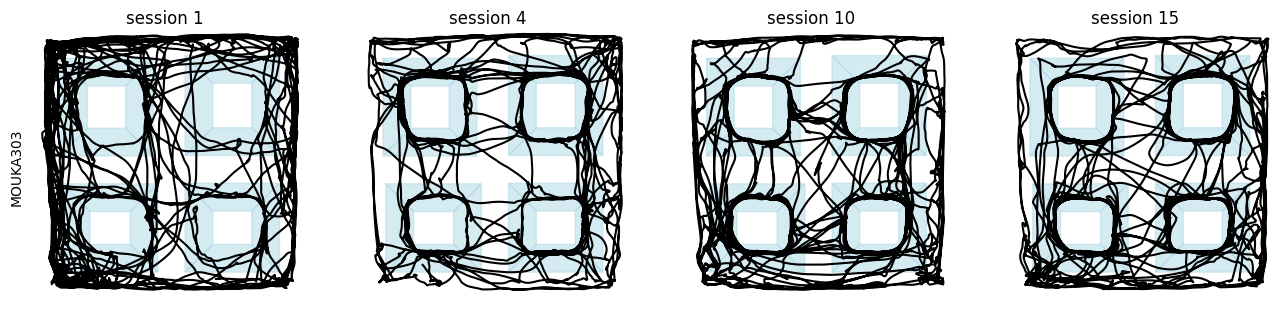

In [16]:
mice_to_plot = mice_list[-3]
folder_path_mouse_to_process = os.path.join(path_to_data_folder, mice_to_plot)

# Get the list of sessions
sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                and name.startswith('MOU')])

nb_sessions = len(sessions_to_process)
print(f'Processing mouse {mice_to_plot}. There is/are {nb_sessions} sessions to process:')
print(sessions_to_process, '\n')


# Create a figure with 4 subplots arranged in 1 row and 4 columns
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
sessions_to_plot=[0, 3, 9, 14]
# Process each session
for index, sessionindex in enumerate(sessions_to_plot):
    session_to_plot=sessions_to_process[sessionindex]
    
    if index==0:
        trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_plot)
        all_trapezes_coordinates_cm= generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]

    # Define the pickle file path
    output_pickle_filename = f"{session_to_plot}_basic_processing_output.pickle"
    output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_plot, output_pickle_filename)
    
    # Check if the pickle file already exists
    if not os.path.exists(output_pickle_filepath):
        print(f'Pickle file does not exists for session {session_to_plot}, skipping .....')
        continue  # Skip loading if the file exists and overwrite is False
    
    # Load the pickle file
    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)
        

    
    positions=np.array(session_data['positions'])
    session_id = f'session {sessionindex+1}'
    if index==0:
        mouse_id = mice_list[-3]
    else:
        mouse_id=''

    plot_trajectory_with_trapezes(positions[0,:], positions[1,:], all_trapezes_coordinates_cm, 
                                  ax=axs[index], xlim=(0, 90), ylim=(0, 90), mouse_id=mouse_id,session_number=session_id ,fill_trapezes=True, plot_borders=False)



        
        # Run the processing if file doesn't exist or overwrite is True
        

In [21]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

def plot_mice_sessions(mice_list, sessions_to_plot, path_to_data_folder):
    num_mice = len(mice_list)
    num_sessions = len(sessions_to_plot)

    # Dynamically compute figure size (you can adjust scaling factors if needed)
    fig_width = num_sessions * 3  # Each subplot has width of 4 units
    fig_height = num_mice * 3     # Each subplot has height of 4 units
    
    fig, axs = plt.subplots(num_mice, num_sessions, figsize=(fig_width, fig_height))
    
    # Ensure axs is 2D array, even if there is only one row or column
    if num_mice == 1:
        axs = np.expand_dims(axs, axis=0)
    if num_sessions == 1:
        axs = np.expand_dims(axs, axis=1)

    # Iterate through each mouse
    for mouse_idx, mouse in enumerate(mice_list):
        folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)

        # Get the list of sessions for the current mouse
        sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                      if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                      and name.startswith('MOU')])

        # Iterate through each session for the current mouse
        for session_idx, session_to_plot_index in enumerate(sessions_to_plot):
            session_to_plot = sessions_to_process[session_to_plot_index]

            # For the first session, extract trapeze and tower data (you can adjust if needed)
            if session_idx == 0:
                trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_plot)
                all_trapezes_coordinates_cm = generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]

            # Define the pickle file path
            output_pickle_filename = f"{session_to_plot}_basic_processing_output.pickle"
            output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_plot, output_pickle_filename)
            
            # Check if the pickle file exists
            if not os.path.exists(output_pickle_filepath):
                print(f'Pickle file does not exist for session {session_to_plot}, skipping .....')
                continue
            
            # Load the pickle file
            with open(output_pickle_filepath, 'rb') as file:
                session_data = pickle.load(file)
            
            # Get the positions
            positions = np.array(session_data['positions'])

            if mouse_idx==0:
                session_id = f'session {session_to_plot_index+1}'
            else:
                session_id = ''
            
            if session_idx==0:
                mouse_id = mouse
            else:
                mouse_id=''

            # Plot the trajectory on the respective subplot
            plot_trajectory_with_trapezes(positions[0, :], positions[1, :], all_trapezes_coordinates_cm, 
                                          ax=axs[mouse_idx, session_idx], xlim=(0, 90), ylim=(0, 90), 
                                          mouse_id=mouse_id,session_number=session_id, fill_trapezes=True, plot_borders=False)
    
    # Display the plot
    plt.tight_layout()
    plt.show()



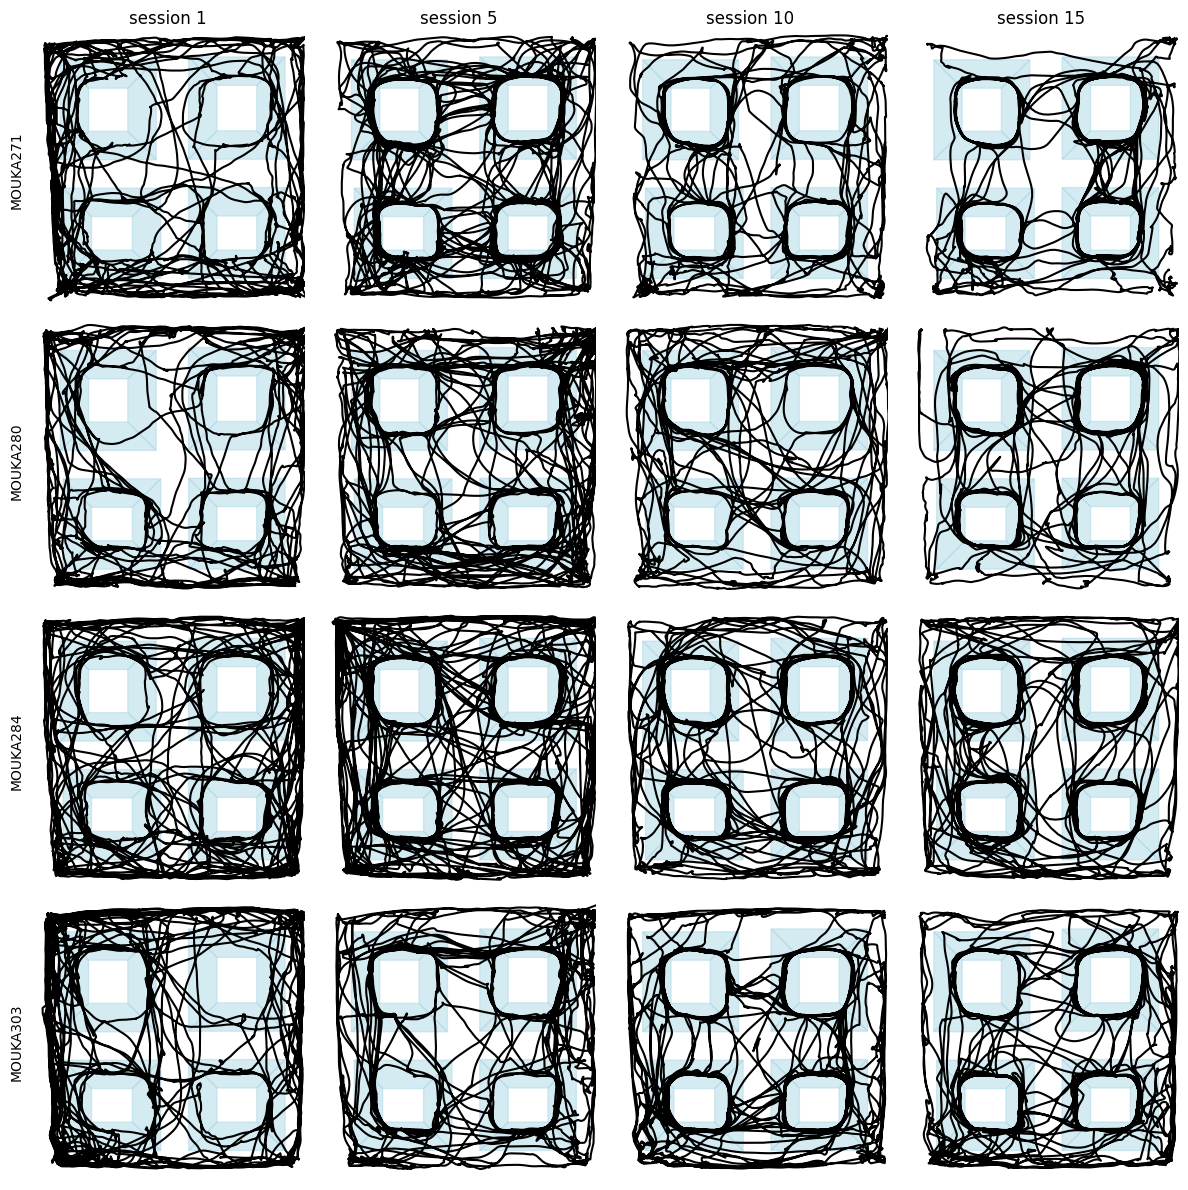

In [22]:


plot_mice_sessions(['MOUKA271','MOUKA280','MOUKA284','MOUKA303'], [0,4,9,14], path_to_data_folder)


In [30]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm




import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

def plot_3d_trajectory(x, y, t, ax=None, session_number='Session 1', 
                                  mouse_id='Mouse ID',):
    """
    Plots a 3D trajectory with (x, y) coordinates and time t as the z-axis.
    The color of the trajectory changes gradually from start to end.

    Parameters:
    - ax: 3D subplot axis (from plt.Axes). If None, a new axis will be created.
    - x: array-like, shape (n,)
    - y: array-like, shape (n,)
    - t: array-like, shape (n,)
    - title: string, title of the subplot
    """
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    # Normalize the time for color mapping
    norm = plt.Normalize(t.min(), t.max())
    colors = cm.viridis(norm(t))

    # Plot 3D line with gradient color
    for i in range(len(x) - 1):
        ax.plot(x[i:i+2], y[i:i+2], t[i:i+2], color=colors[i])

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Time (Z)')
    ax.set_title(session_number)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

def plot_3d_trajectory(x, y, t, ax=None, session_number='Session 1', mouse_id='Mouse ID'):
    """
    Plots a 3D trajectory with (x, y) coordinates and time t as the z-axis.
    The color of the trajectory changes gradually from start to end.

    Parameters:
    - ax: 3D subplot axis (from plt.Axes). If None, a new axis will be created.
    - x: array-like, shape (n,)
    - y: array-like, shape (n,)
    - t: array-like, shape (n,)
    - session_number: string, title of the subplot (Session number).
    - mouse_id: string, label for the y-axis on the left (Mouse ID).
    """
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    # Normalize the time for color mapping
    norm = plt.Normalize(t.min(), t.max())
    colors = cm.viridis(norm(t))

    # Plot 3D line with gradient color
    for i in range(len(x) - 1):
        ax.plot(x[i:i+2], y[i:i+2], t[i:i+2], color=colors[i])

    # # Set the x and y labels
    # ax.set_xlabel('x-position (cm)')
    # ax.set_ylabel('y-position (cm)')

    # Hide z label, ticks, and tick labels for all axes
    ax.set_zticks([])
    ax.set_xticks([])
    ax.set_yticks([])

    # Title with the session number
    ax.set_title(session_number)

    # Place the mouse ID as a vertical label on the left
    ax.text2D(-0.1, 0.5, mouse_id, rotation=90, va='center', ha='center', transform=ax.transAxes)








def plot_3dtrajectory_mice_sessions(mice_list, sessions_to_plot, path_to_data_folder):
    num_mice = len(mice_list)
    num_sessions = len(sessions_to_plot)

    # Dynamically compute figure size (you can adjust scaling factors if needed)
    fig_width = num_sessions * 3  # Each subplot has width of 4 units
    fig_height = num_mice * 3     # Each subplot has height of 4 units
    
    fig, axs = plt.subplots(num_mice, num_sessions, figsize=(fig_width, fig_height), subplot_kw={'projection': '3d'})
    
    
    # Ensure axs is 2D array, even if there is only one row or column
    if num_mice == 1:
        axs = np.expand_dims(axs, axis=0)
    if num_sessions == 1:
        axs = np.expand_dims(axs, axis=1)

    # Iterate through each mouse
    for mouse_idx, mouse in enumerate(mice_list):
        folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)

        # Get the list of sessions for the current mouse
        sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                      if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                      and name.startswith('MOU')])

        # Iterate through each session for the current mouse
        for session_idx, session_to_plot_index in enumerate(sessions_to_plot):
            session_to_plot = sessions_to_process[session_to_plot_index]

            # For the first session, extract trapeze and tower data (you can adjust if needed)
            if session_idx == 0:
                trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_plot)
                all_trapezes_coordinates_cm = generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]

            # Define the pickle file path
            output_pickle_filename = f"{session_to_plot}_basic_processing_output.pickle"
            output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_plot, output_pickle_filename)
            
            # Check if the pickle file exists
            if not os.path.exists(output_pickle_filepath):
                print(f'Pickle file does not exist for session {session_to_plot}, skipping .....')
                continue
            
            # Load the pickle file
            with open(output_pickle_filepath, 'rb') as file:
                session_data = pickle.load(file)
            
            # Get the positions
            positions = np.array(session_data['positions'])
            timeofframes=session_data['timeofframes']
            
            if mouse_idx==0:
                session_id = f'session {session_to_plot_index+1}'
            else:
                session_id = ''
            
            if session_idx==0:
                mouse_id = mouse
            else:
                mouse_id=''

            # Plot the trajectory on the respective subplot
            plot_3d_trajectory(positions[0, :], positions[1, :], timeofframes, ax=axs[mouse_idx, session_idx], session_number=session_id, mouse_id=mouse_id)
            
    
    # Display the plot
    plt.tight_layout()
    plt.show()



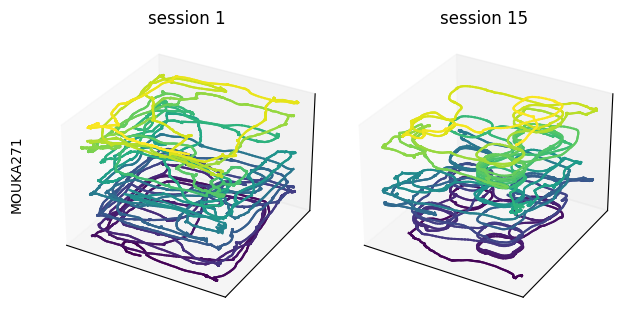

In [27]:
plot_3dtrajectory_mice_sessions(['MOUKA271'], [0,14], path_to_data_folder)

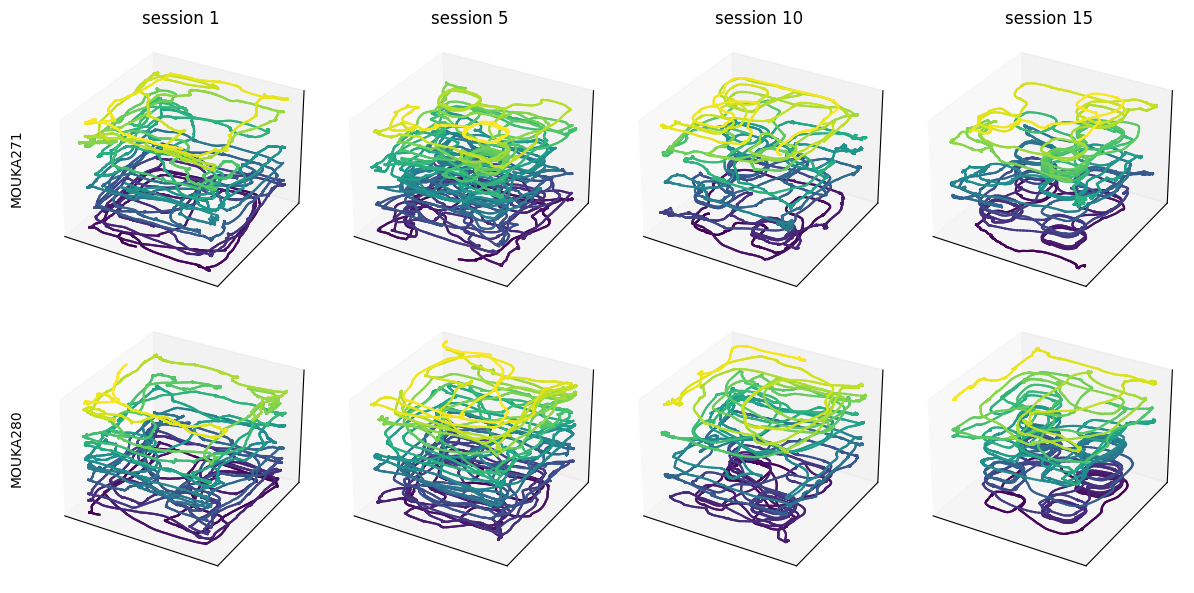

In [31]:
plot_3dtrajectory_mice_sessions(['MOUKA271','MOUKA280'], [0,4,9,14], path_to_data_folder)

In [8]:
assert False, "Stopping execution here." 

AssertionError: Stopping execution here.

In [ ]:
mice_to_analyse = mice_list
# Initialize the dictionary with empty lists for each mouse
mouse_distanceran_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_CCW_ratio_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_average_speed_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_total_turns_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_total_rewardedturns_persession = {mouse: [] for mouse in mice_to_analyse}



for mouse in mice_to_analyse:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Mouse {mouse}. There is/are {nb_sessions} sessions:')
    #print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        print(f'Getting the pickle file of session {session_to_process}')
        
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exists for session {session_to_process}, skipping .....')
            continue  # Skip loading if the file exists and overwrite is False
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)
            
        run_around_tower_sessionresult=session_data['run_around_tower_sessionresult']
        CCWRatio=run_around_tower_sessionresult['All']['total_CCW']/(run_around_tower_sessionresult['All']['total_CCW']+run_around_tower_sessionresult['All']['total_CW'])
        TotalTurns=run_around_tower_sessionresult['All']['total_CCW']+run_around_tower_sessionresult['All']['total_CW']
        TotalRewardedTurns=run_around_tower_sessionresult['All']['rewarded_CW']+run_around_tower_sessionresult['All']['rewarded_CCW']
        mouse_CCW_ratio_persession[mouse].append([sessionindex+1,CCWRatio])
        mouse_distanceran_persession[mouse].append([sessionindex+1,session_data['distance_ran']])
        mouse_average_speed_persession[mouse].append([sessionindex+1,session_data['average_speed']])
        mouse_total_turns_persession[mouse].append([sessionindex+1,TotalTurns])
        mouse_total_rewardedturns_persession[mouse].append([sessionindex+1,TotalRewardedTurns])






        
        # Run the processing if file doesn't exist or overwrite is True
        

Mouse MOUKA267. There is/are 19 sessions:
Getting the pickle file of session MOUKA267_20230531-1519
Getting the pickle file of session MOUKA267_20230601-0939
Getting the pickle file of session MOUKA267_20230601-1521
Getting the pickle file of session MOUKA267_20230602-0912
Getting the pickle file of session MOUKA267_20230602-1504
Getting the pickle file of session MOUKA267_20230605-0938
Getting the pickle file of session MOUKA267_20230605-1620
Getting the pickle file of session MOUKA267_20230606-1103
Getting the pickle file of session MOUKA267_20230606-1638
Pickle file does not exists for session MOUKA267_20230606-1638, skipping .....
Getting the pickle file of session MOUKA267_20230607-0939
Getting the pickle file of session MOUKA267_20230607-1450
Getting the pickle file of session MOUKA267_20230608-0957
Getting the pickle file of session MOUKA267_20230608-1545
Getting the pickle file of session MOUKA267_20230609-1042
Getting the pickle file of session MOUKA267_20230609-1613
Getting t

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_learning_curves(mouse_distanceran_persession, mice_list=None, ylabel='Distance Ran', title='Learning Curve: Distance Ran vs. Session Number', tick_interval=1, ylim=None, show_legend=True):
    plt.figure(figsize=(12, 6))

    # If no mice are specified, use all available mice
    if mice_list is None:
        mice_list = list(mouse_distanceran_persession.keys())

    all_session_indices = set()  # Track all session indices across selected mice

    for mouse in mice_list:
        if mouse not in mouse_distanceran_persession:
            print(f"Mouse {mouse} not found in data. Skipping.")
            continue

        sessions = mouse_distanceran_persession[mouse]
        
        # Extract session indices and distances
        session_indices = [session[0] for session in sessions]
        distances = [session[1] for session in sessions]

        plt.plot(session_indices, distances, marker='o', label=f'Mouse {mouse}')
        
        # Update all_session_indices
        all_session_indices.update(session_indices)

    plt.xlabel('Session Number')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    
    # Ensure x-axis labels are integers and start from 1
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Set x-ticks with custom spacing
    if all_session_indices:
        max_index = max(all_session_indices)
        plt.xticks(range(1, max_index + 1, tick_interval))

    # Set y-axis limits if specified
    if ylim is not None:
        plt.ylim(ylim)

    # Show legend if specified
    if show_legend:
        plt.legend()

    plt.show()


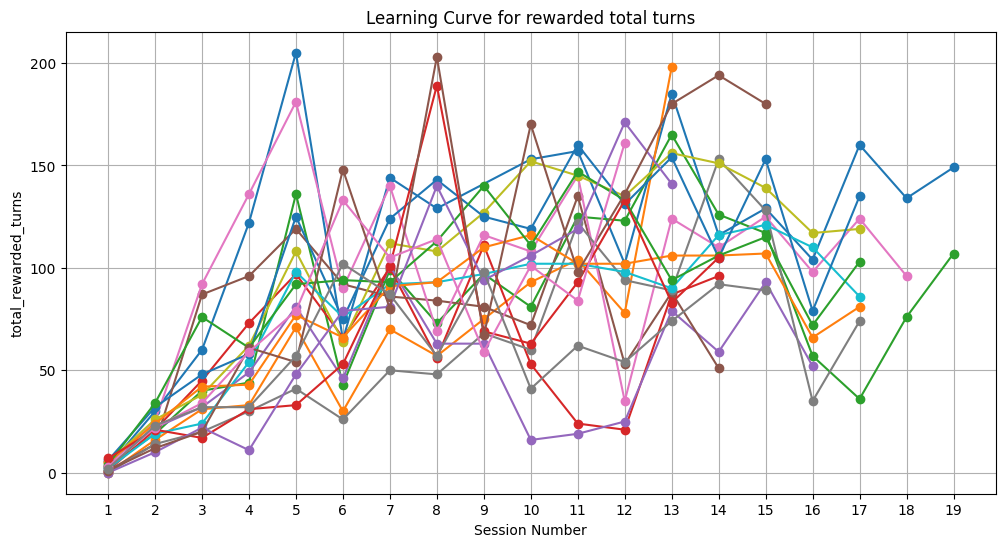

In [ ]:

# Example usage
plot_learning_curves(mouse_total_rewardedturns_persession, ylabel='total_rewarded_turns', title='Learning Curve for rewarded total turns', tick_interval=1,show_legend=False)


In [ ]:
# Maud's function to calculate time and distance spent in zones 

import matplotlib.path as mpath # to put with all imports

border_zone = [
    [(3, 3), (10, 3), (10, 90), (3, 90)],  # left
    [(3, 3), (3, 9.5), (92, 9.5), (92, 3)],  # down
    [(84, 3), (92, 3), (92, 90), (84, 90)],  # right
    [(3, 83), (3, 90), (92, 90), (92, 83)]   # up
]

def calculate_time_distance_in_zones(smoothed_Xpositions_cm, smoothed_Ypositions_cm, traject_time, 
                            all_trapezes_coordinates_cm, border_zone):
    # 1. Border zones (red)
    border_polygons = [
        mpath.Path(border_zone[0]),  # Left
        mpath.Path(border_zone[1]),  # Bottom
        mpath.Path(border_zone[2]),  # Right
        mpath.Path(border_zone[3])   # Top
    ]
    
    # 2. Trapezes zones (white)
    trapeze_polygons = []
    for tower, trapezes in all_trapezes_coordinates_cm.items():
        for trapeze, coords in trapezes.items():
            trapeze_polygons.append(mpath.Path(coords))
    
    # 3. Interior zone (green)
    inner_setup_size = (10, 9.5, 84, 83)
    interior_polygon = mpath.Path([
        (inner_setup_size[0], inner_setup_size[1]),
        (inner_setup_size[0], inner_setup_size[3]),
        (inner_setup_size[2], inner_setup_size[3]),
        (inner_setup_size[2], inner_setup_size[1])
    ])
    
    # 4. Variables to store the time/distance spent in each zone
    time_in_border = 0
    time_in_trapeze = 0
    time_in_interior = 0
    distance_in_border = 0
    distance_in_trapeze = 0
    distance_in_interior = 0
    
    # 5. Browse the positions of the trajectory and calculate the time spent in each zone
    for i in range(len(smoothed_Xpositions_cm)):
        point = np.array([smoothed_Xpositions_cm[i], smoothed_Ypositions_cm[i]])
        
        # Calculate the time interval between each point
        if i < len(traject_time) - 1:
            dt = traject_time[i+1] - traject_time[i]
        else:
            dt = 0  # last point, no time interval

        # Test if the point is in the 'border' area (red)
        if any(polygon.contains_point(point) for polygon in border_polygons):
            time_in_border += dt

        # Test if the point is in the 'trapeze' area (white)
        elif any(polygon.contains_point(point) for polygon in trapeze_polygons):
            time_in_trapeze += dt

        # Test if the point is in the 'interior' area (green)
        elif interior_polygon.contains_point(point):
            time_in_interior += dt
    
    # 6. Browse the positions of the trajectory and calculate the distance traveled in each zone # TODO 

    for i in range(len(smoothed_Xpositions_cm) - 1):
        point_start = np.array([smoothed_Xpositions_cm[i], smoothed_Ypositions_cm[i]])
        point_end = np.array([smoothed_Xpositions_cm[i+1], smoothed_Ypositions_cm[i+1]])
        
        # Calculer la distance entre deux points successifs
        distance = np.linalg.norm(point_end - point_start)

        # Tester si le point initial est dans la zone 'border' (rouge)
        if any(polygon.contains_point(point_start) for polygon in border_polygons):
            distance_in_border += distance

        # Tester si le point initial est dans la zone 'trapeze' (blanche)
        elif any(polygon.contains_point(point_start) for polygon in trapeze_polygons):
            distance_in_trapeze += distance

        # Sinon, le point initial est dans la zone intérieure (verte)
        elif interior_polygon.contains_point(point_start):
            distance_in_interior += distance

    # 6. Return results in a dictionary, rounded to 2 decimal places
    time_spent_in_zones = {
        'border': round(time_in_border, 2),
        'trapeze': round(time_in_trapeze, 2),
        'interior': round(time_in_interior, 2)
    }

    distance_covered_in_zones = {
        'border': round(distance_in_border, 2),
        'trapeze': round(distance_in_trapeze, 2),
        'interior': round(distance_in_interior, 2)
    }
    
    return time_spent_in_zones, distance_covered_in_zones

In [ ]:
mice_to_analyse = mice_list
# Initialize the dictionary with empty lists for each mouse
mouse_timeratio_exploitvsexplore_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_distanceratio_exploitvsexplore_persession = {mouse: [] for mouse in mice_to_analyse}


for mouse in mice_to_analyse:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_analyse)
    print(f'Mouse {mouse}. There is/are {nb_sessions} sessions:')
    #print(sessions_to_analyse, '\n')
    
    # Process each session
    for sessionindex,session_to_analyse in enumerate(sessions_to_analyse):
        print(f'Getting the pickle file of session {session_to_analyse}')
        
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_analyse, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exists for session {session_to_analyse}, skipping .....')
            continue  # Skip loading if the file exists and overwrite is False
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)
            
        smoothed_positions_cm=session_data['positions']
        time_video_frames=session_data['timeofframes']
        all_trapezes_coordinates_cm=session_data['all_trapezes_coordinates_cm']
        time_spentinzones,distance_spentinzones=calculate_time_distance_in_zones(smoothed_positions_cm[0], smoothed_positions_cm[1], time_video_frames, 
                            all_trapezes_coordinates_cm, border_zone)
        

        mouse_timeratio_exploitvsexplore_persession[mouse].append([sessionindex+1,(time_spentinzones['trapeze']+time_spentinzones['interior'])/time_spentinzones['border']])
        mouse_distanceratio_exploitvsexplore_persession[mouse].append([sessionindex+1,(distance_spentinzones['trapeze']+distance_spentinzones['interior'])/distance_spentinzones['border']])






        
        # Run the processing if file doesn't exist or overwrite is True
        

Mouse MOUKA267. There is/are 19 sessions:
Getting the pickle file of session MOUKA267_20230531-1519
Getting the pickle file of session MOUKA267_20230601-0939
Getting the pickle file of session MOUKA267_20230601-1521
Getting the pickle file of session MOUKA267_20230602-0912
Getting the pickle file of session MOUKA267_20230602-1504
Getting the pickle file of session MOUKA267_20230605-0938
Getting the pickle file of session MOUKA267_20230605-1620
Getting the pickle file of session MOUKA267_20230606-1103
Getting the pickle file of session MOUKA267_20230606-1638
Pickle file does not exists for session MOUKA267_20230606-1638, skipping .....
Getting the pickle file of session MOUKA267_20230607-0939
Getting the pickle file of session MOUKA267_20230607-1450
Getting the pickle file of session MOUKA267_20230608-0957
Getting the pickle file of session MOUKA267_20230608-1545
Getting the pickle file of session MOUKA267_20230609-1042
Getting the pickle file of session MOUKA267_20230609-1613
Getting t

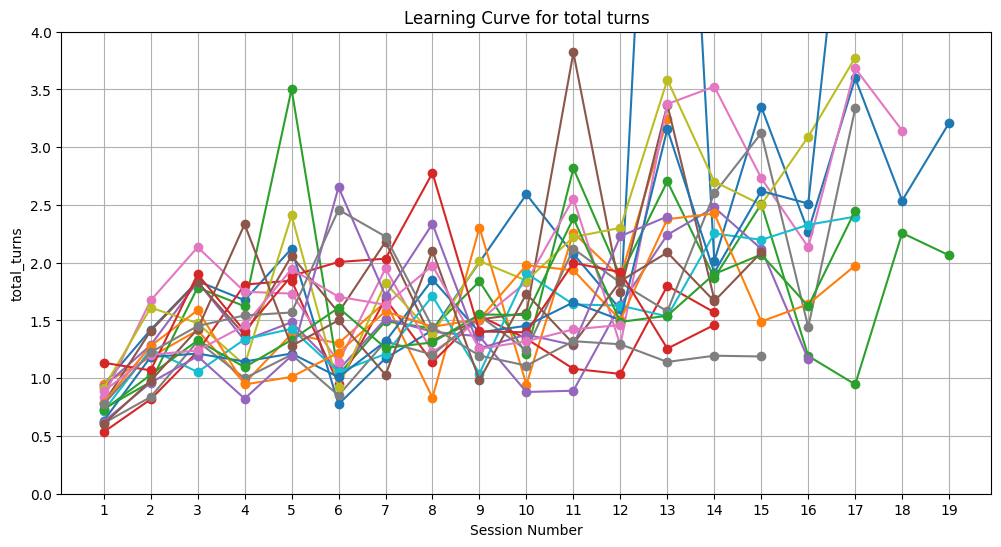

In [ ]:

# Example usage
plot_learning_curves(mouse_timeratio_exploitvsexplore_persession, ylabel='total_turns', title='Learning Curve for total turns', tick_interval=1,ylim=[0, 4],show_legend=False)


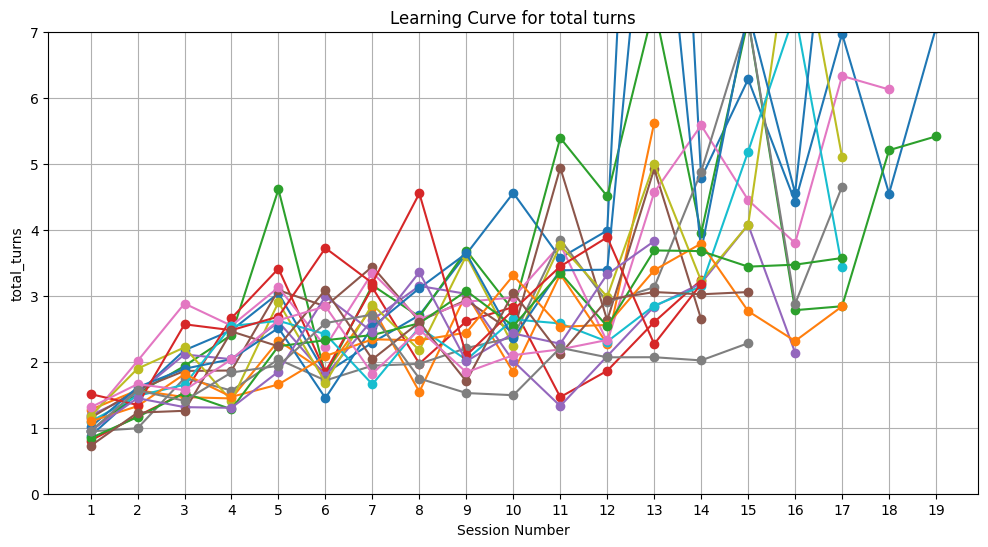

In [ ]:

# Example usage
plot_learning_curves(mouse_distanceratio_exploitvsexplore_persession, ylabel='total_turns', title='Learning Curve for total turns', tick_interval=1,show_legend=False,ylim=[0, 7])


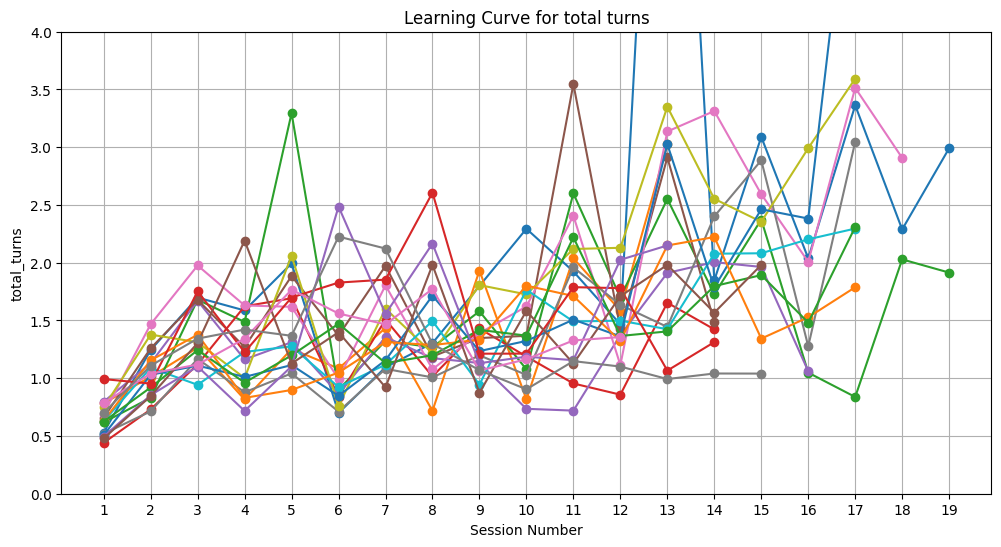

In [ ]:

# Example usage
plot_learning_curves(mouse_timeratio_trapezevsborder_persession, ylabel='total_turns', title='Learning Curve for total turns', tick_interval=1,ylim=[0, 4],show_legend=False)


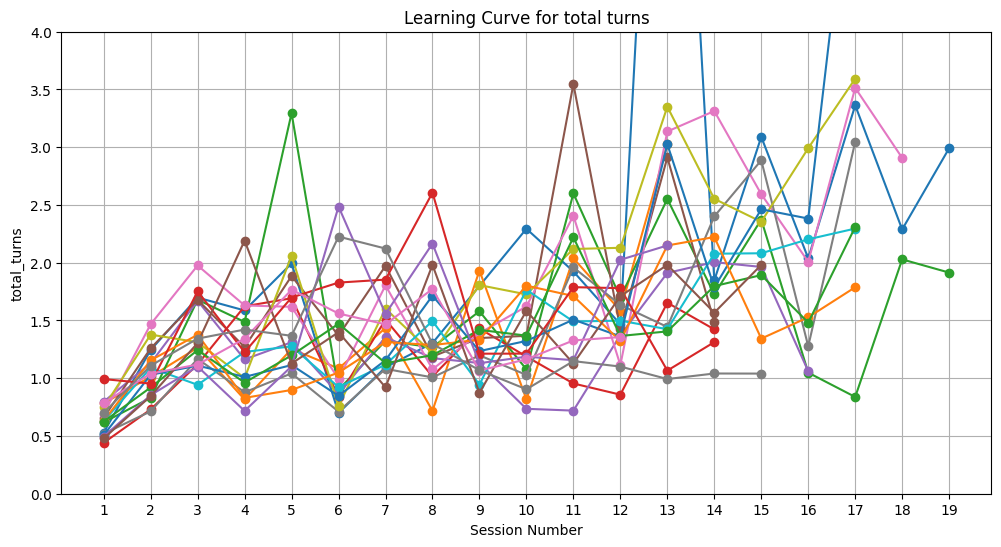

In [ ]:

# Example usage
plot_learning_curves(mouse_timeratio_trapezevsborder_persession, ylabel='total_turns', title='Learning Curve for total turns', tick_interval=1,ylim=[0, 4],show_legend=False)


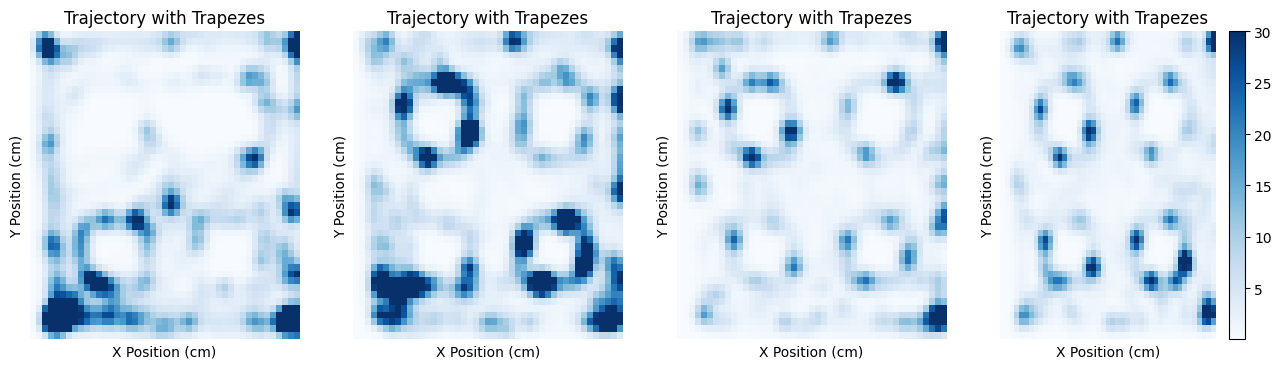

In [ ]:

# Create a figure with 4 subplots arranged in 1 row and 4 columns
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
sessions_to_plot=[0, 4, 11, 17]
colorbars=[False,False,False,True]
# Process each session
for index, sessionindex in enumerate(sessions_to_plot):
    session_to_plot=sessions_to_process[sessionindex]
    
    if index==0:
        trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_plot)
        all_trapezes_coordinates_cm= generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]

    # Define the pickle file path
    output_pickle_filename = f"{session_to_plot}_basic_processing_output.pickle"
    output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_plot, output_pickle_filename)
    
    # Check if the pickle file already exists
    if not os.path.exists(output_pickle_filepath):
        print(f'Pickle file does not exists for session {session_to_plot}, skipping .....')
        continue  # Skip loading if the file exists and overwrite is False
    
    # Load the pickle file
    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)
        

    
    positions=np.array(session_data['positions'])
    title_name = f'session {sessionindex+1}'
    plot_trajectory_density(positions[0,:], positions[1,:], all_trapezes_coordinates_cm, 
                        ax=axs[index], xlim=(0, 90), ylim=(0, 90), plot_borders=False,border_colors=['white'],densitymax=30,bin_size=2,plotcolorbar=colorbars[index])
    


        
        # Run the processing if file doesn't exist or overwrite is True
        

In [ ]:

from matplotlib.ticker import MaxNLocator

def plot_learning_curves(mouse_distanceran_persession, ylabel='Distance Ran', title='Learning Curve: Distance Ran vs. Session Number', tick_interval=1):
    plt.figure(figsize=(12, 6))

    all_session_indices = set()  # Track all session indices across mice

    for mouse, sessions in mouse_distanceran_persession.items():
        # Extract session indices and distances
        session_indices = [session[0] for session in sessions]
        distances = [session[1] for session in sessions]

        plt.plot(session_indices, distances, marker='o', label=f'Mouse {mouse}')
        
        # Update all_session_indices
        all_session_indices.update(session_indices)

    plt.xlabel('Session Number')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
    # Ensure x-axis labels are integers and start from 1
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Set x-ticks with custom spacing
    if all_session_indices:
        max_index = max(all_session_indices)
        plt.xticks(range(1, max_index , tick_interval))

    plt.show()


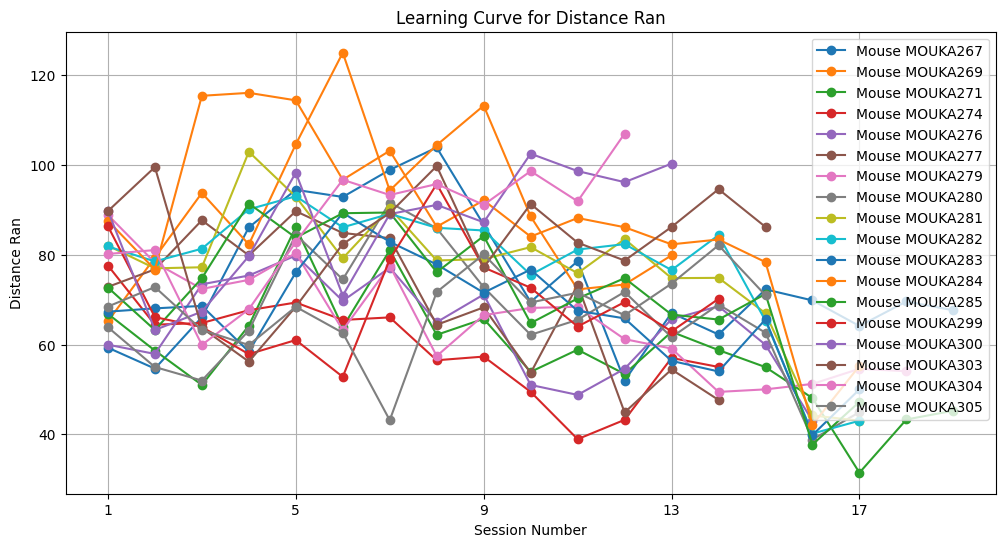

In [ ]:

# Example usage
plot_learning_curves(mouse_distanceran_persession, ylabel='Distance Ran', title='Learning Curve for Distance Ran', tick_interval=4)


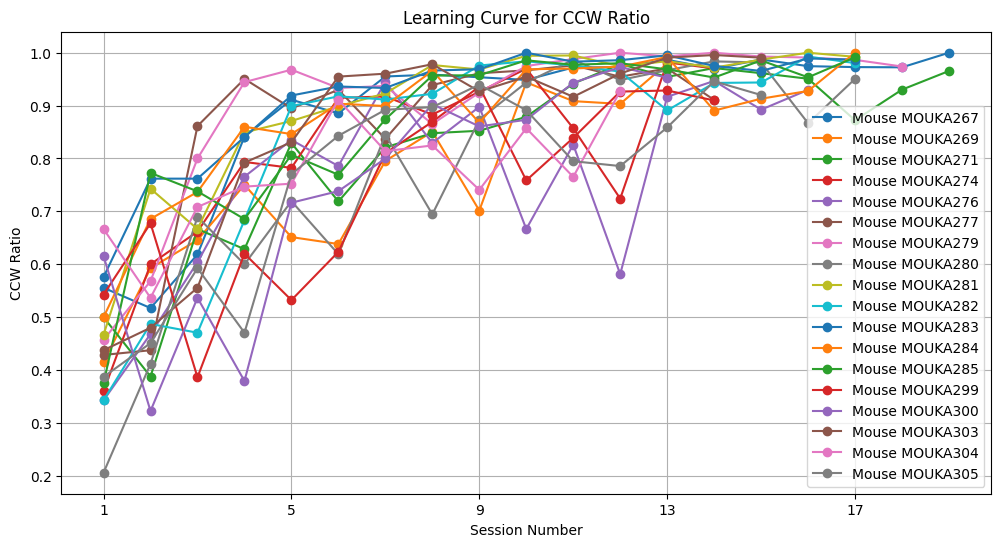

In [ ]:

plot_learning_curves(mouse_CCW_ratio_persession, ylabel='CCW Ratio', title='Learning Curve for CCW Ratio', tick_interval=4)

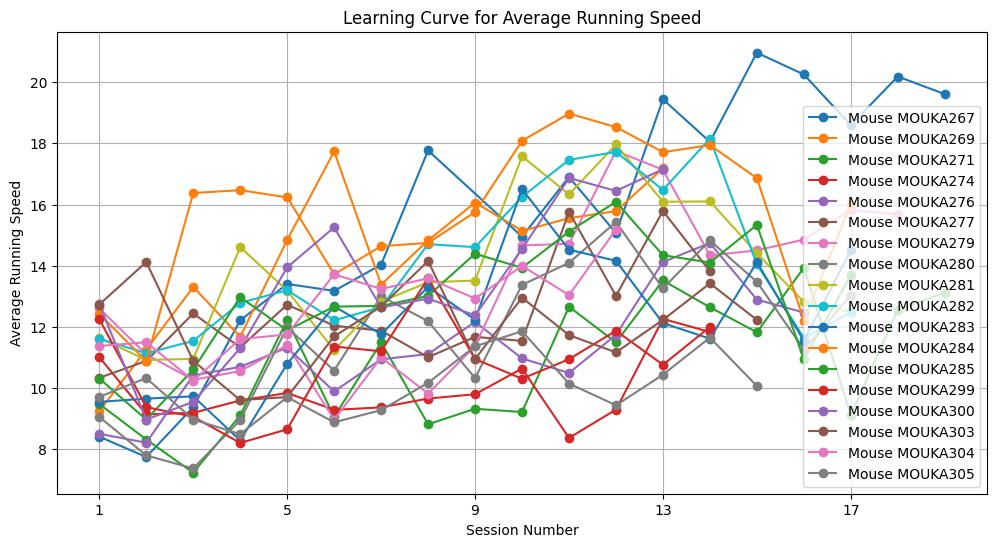

In [ ]:

plot_learning_curves(mouse_average_speed_persession, ylabel='Average Running Speed', title='Learning Curve for Average Running Speed', tick_interval=4)

In [ ]:
runs_around_tower=session_data['all_epochs']['run_around_tower']

In [ ]:
runs_around_tower[0]

[[6, 29],
 ['SW', 'E'],
 ['SW', 'N'],
 {'Rewarded': True, 'direction': 'CCW', 'num_trapezeswitch': 1},
 {'epoch_time': np.float64(15.248),
  'epoch_duration': np.float64(0.9199999999999999),
  'epoch_distance': np.float64(13.589556057765511),
  'epoch_meanspeed': np.float64(14.77125658452773),
  'epoch_maxspeed': np.float64(28.295012991018886)}]

In [ ]:
speed_runs_around_tower={'CW':[], 'CCW':[]}
if speed_runs_around_tower['CCW']:
    print('hello')

In [ ]:
mice_to_process = mice_list
# Initialize the dictionary with empty lists for each mouse
mouse_average_speed_around_tower_persession = {mouse: [] for mouse in mice_to_process}
directions = ['CW', 'CCW']

for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Mouse {mouse}. There is/are {nb_sessions} sessions:')
    #print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        print(f'Getting the pickle file of session {session_to_process}')
        
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exists for session {session_to_process}, skipping .....')
            continue  # Skip loading if the file exists and overwrite is False
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)

        mouse_average_speed_around_tower_persession[mouse] = {'CW':[], 'CCW':[]}



        runs_around_tower=session_data['all_epochs']['run_around_tower']
        speed_runs_around_tower={'CW':[], 'CCW':[]}
        for run_around_tower in runs_around_tower:
            if run_around_tower[3]['num_trapezeswitch']<2:
                speed_run_around_tower=run_around_tower[4]['epoch_meanspeed']
                direction_run_around_tower=run_around_tower[3]['direction']
                speed_runs_around_tower[direction_run_around_tower].append(speed_run_around_tower)
        
        for direction in directions:
            if speed_runs_around_tower[direction]:
                mouse_average_speed_around_tower_persession[mouse][direction].append([sessionindex+1,np.mean(speed_runs_around_tower[direction])])
            







Mouse MOUKA267. There is/are 19 sessions:
Getting the pickle file of session MOUKA267_20230531-1519
Getting the pickle file of session MOUKA267_20230601-0939
Getting the pickle file of session MOUKA267_20230601-1521
Getting the pickle file of session MOUKA267_20230602-0912
Getting the pickle file of session MOUKA267_20230602-1504
Getting the pickle file of session MOUKA267_20230605-0938
Getting the pickle file of session MOUKA267_20230605-1620
Getting the pickle file of session MOUKA267_20230606-1103
Getting the pickle file of session MOUKA267_20230606-1638
Pickle file does not exists for session MOUKA267_20230606-1638, skipping .....
Getting the pickle file of session MOUKA267_20230607-0939
Getting the pickle file of session MOUKA267_20230607-1450
Getting the pickle file of session MOUKA267_20230608-0957
Getting the pickle file of session MOUKA267_20230608-1545
Getting the pickle file of session MOUKA267_20230609-1042
Getting the pickle file of session MOUKA267_20230609-1613
Getting t

In [ ]:
mice_to_process = mice_list
directions = ['CW', 'CCW']

# Initialize the dictionary with empty lists for each direction and mouse
mouse_average_speed_around_tower_persession = {direction: {mouse: [] for mouse in mice_to_process} for direction in directions}

for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Mouse {mouse}. There is/are {nb_sessions} sessions:')
    
    # Process each session
    for sessionindex, session_to_process in enumerate(sessions_to_process):
        print(f'Getting the pickle file of session {session_to_process}')
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exist for session {session_to_process}, skipping .....')
            continue  # Skip loading if the file does not exist
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)
        
        # Initialize run speeds for both directions
        speed_runs_around_tower = {'CW': [], 'CCW': []}
        
        # Process the runs around the tower
        runs_around_tower = session_data['all_epochs']['run_around_tower']
        for run_around_tower in runs_around_tower:
            if run_around_tower[3]['num_trapezeswitch'] < 2:
                speed_run_around_tower = run_around_tower[4]['epoch_meanspeed']
                direction_run_around_tower = run_around_tower[3]['direction']
                speed_runs_around_tower[direction_run_around_tower].append(speed_run_around_tower)
        
        # Store the average speeds per direction
        for direction in directions:
            if speed_runs_around_tower[direction]:
                avg_speed = np.mean(speed_runs_around_tower[direction])
                mouse_average_speed_around_tower_persession[direction][mouse].append([sessionindex + 1, avg_speed])


Mouse MOUKA267. There is/are 19 sessions:
Getting the pickle file of session MOUKA267_20230531-1519
Getting the pickle file of session MOUKA267_20230601-0939
Getting the pickle file of session MOUKA267_20230601-1521
Getting the pickle file of session MOUKA267_20230602-0912
Getting the pickle file of session MOUKA267_20230602-1504
Getting the pickle file of session MOUKA267_20230605-0938
Getting the pickle file of session MOUKA267_20230605-1620
Getting the pickle file of session MOUKA267_20230606-1103
Getting the pickle file of session MOUKA267_20230606-1638
Pickle file does not exist for session MOUKA267_20230606-1638, skipping .....
Getting the pickle file of session MOUKA267_20230607-0939
Getting the pickle file of session MOUKA267_20230607-1450
Getting the pickle file of session MOUKA267_20230608-0957
Getting the pickle file of session MOUKA267_20230608-1545
Getting the pickle file of session MOUKA267_20230609-1042
Getting the pickle file of session MOUKA267_20230609-1613
Getting th

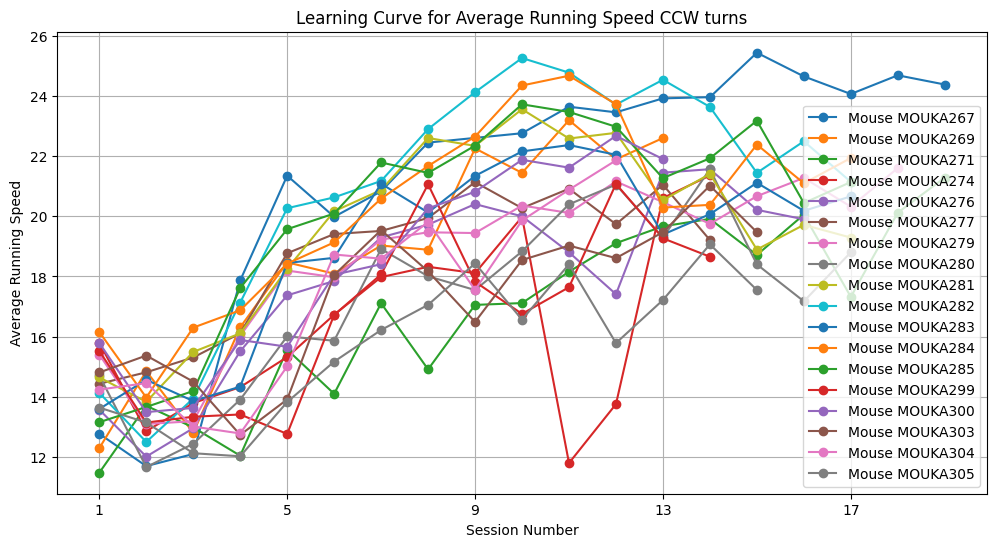

In [ ]:

plot_learning_curves(mouse_average_speed_around_tower_persession['CCW'], ylabel='Average Running Speed', title='Learning Curve for Average Running Speed CCW turns', tick_interval=4)

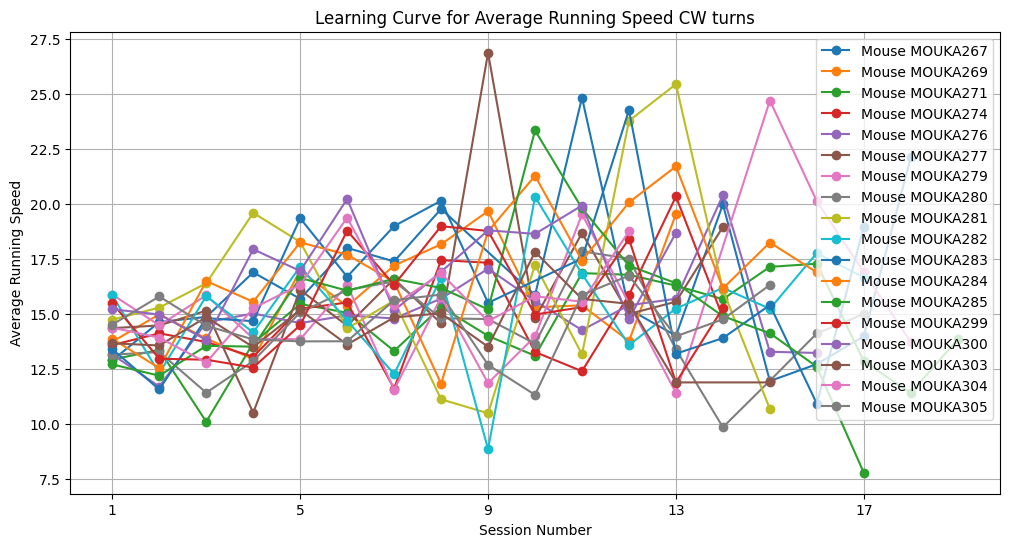

In [ ]:

plot_learning_curves(mouse_average_speed_around_tower_persession['CW'], ylabel='Average Running Speed', title='Learning Curve for Average Running Speed CW turns', tick_interval=4)

### Get the pickle of all the sessions of the mice to quantifiy


In [ ]:
mice_to_process = [mice_list[0]]
# Initialize the dictionary with empty lists for each mouse
mouse_trajectories = {mouse: [] for mouse in mice_to_process}

for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        print(f'Getting the run trajectory of session {session_to_process}')
        
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exists for session {session_to_process}, skipping .....')
            continue  # Skip loading if the file exists and overwrite is False
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)
            print(session_data['average_speed'])

        runs_around_tower=session_data['all_epochs']['run_around_tower']
        positions=np.array(session_data['positions'])
        for run_around_tower in runs_around_tower:
            if run_around_tower[3]['num_trapezeswitch']==1:
                run_trajectory=positions[:,run_around_tower[0][0]:run_around_tower[0][1]]
                mouse_trajectories[mouse].append(run_trajectory)



        
        # Run the processing if file doesn't exist or overwrite is True
        

Processing mouse MOUKA271. There is/are 19 sessions to process:
['MOUKA271_20230607-1401', 'MOUKA271_20230608-1053', 'MOUKA271_20230608-1638', 'MOUKA271_20230609-1135', 'MOUKA271_20230609-1706', 'MOUKA271_20230612-1053', 'MOUKA271_20230612-1604', 'MOUKA271_20230613-1011', 'MOUKA271_20230613-1549', 'MOUKA271_20230614-1008', 'MOUKA271_20230614-1551', 'MOUKA271_20230615-1010', 'MOUKA271_20230615-1559', 'MOUKA271_20230616-0944', 'MOUKA271_20230616-1512', 'MOUKA271_20230619-0946', 'MOUKA271_20230619-1514', 'MOUKA271_20230620-0930', 'MOUKA271_20230620-1511'] 

Getting the run trajectory of session MOUKA271_20230607-1401
9.482164751708822
Getting the run trajectory of session MOUKA271_20230608-1053
8.32231757809947
Getting the run trajectory of session MOUKA271_20230608-1638
7.237063794765522
Getting the run trajectory of session MOUKA271_20230609-1135
9.11088055511185
Getting the run trajectory of session MOUKA271_20230609-1706
12.231580597841903
Getting the run trajectory of session MOUKA27

In [ ]:
trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_process)
all_trapezes_coordinates_cm,towers_coordinates_cm= generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)

In [ ]:
towers_coordinates_cm

{'NW': [[19.28, 71.76], [32.08, 71.76], [32.08, 57.67], [19.28, 57.67]],
 'NE': [[61.19, 72.69], [74.17, 72.69], [74.17, 57.85], [61.19, 57.85]],
 'SW': [[20.21, 29.85], [33.56, 29.85], [33.56, 18.91], [20.21, 18.91]],
 'SE': [[61.19, 30.04], [74.17, 30.04], [74.17, 18.91], [61.19, 18.91]]}

In [ ]:
towers_coordinates_cm = {
    'NW': [[19.28, 71.76], [32.08, 71.76], [32.08, 57.67], [19.28, 57.67]],
    'NE': [[61.19, 72.69], [74.17, 72.69], [74.17, 57.85], [61.19, 57.85]],
    'SW': [[20.21, 29.85], [33.56, 29.85], [33.56, 18.91], [20.21, 18.91]],
    'SE': [[61.19, 30.04], [74.17, 30.04], [74.17, 18.91], [61.19, 18.91]]
}

# Define new dictionary with explicit corner names
clean_towers_coordinates = {}

# Corner names in order
corner_names = ['NW', 'NE', 'SE', 'SW']

for tower, coordinates in towers_coordinates_cm.items():
    clean_towers_coordinates[tower] = {corner_names[i]: coord for i, coord in enumerate(coordinates)}

# Display transformed dictionary
clean_towers_coordinates


{'NW': {'NW': [19.28, 71.76],
  'NE': [32.08, 71.76],
  'SE': [32.08, 57.67],
  'SW': [19.28, 57.67]},
 'NE': {'NW': [61.19, 72.69],
  'NE': [74.17, 72.69],
  'SE': [74.17, 57.85],
  'SW': [61.19, 57.85]},
 'SW': {'NW': [20.21, 29.85],
  'NE': [33.56, 29.85],
  'SE': [33.56, 18.91],
  'SW': [20.21, 18.91]},
 'SE': {'NW': [61.19, 30.04],
  'NE': [74.17, 30.04],
  'SE': [74.17, 18.91],
  'SW': [61.19, 18.91]}}

In [ ]:
def get_tower_and_corner(run_around_tower):
    # Get the label of the tower and corner  around wich a run around tower is happening based on the  second and third elements saved in run_epochs['run_around_tower']
    tower_name = run_around_tower[1][0]  # First element, 'NE', gives the tower
    start_face = run_around_tower[1][1]  # 'W' for west, gives the starting face
    end_face = run_around_tower[2][1]    # 'S' for south, gives the ending face
    
    # Determine the corner based on the start and end faces
    if start_face == 'W' and end_face == 'S':
        corner = 'SW'
    elif start_face == 'S' and end_face == 'E':
        corner = 'SE'
    elif start_face == 'E' and end_face == 'N':
        corner = 'NE'
    elif start_face == 'N' and end_face == 'W':
        corner = 'NW'
    elif start_face == 'W' and end_face == 'N':
        corner = 'NW'
    elif start_face == 'N' and end_face == 'E':
        corner = 'NE'
    elif start_face == 'E' and end_face == 'S':
        corner = 'SE'
    elif start_face == 'S' and end_face == 'W':
        corner = 'SW'
    else:
        corner = None  # Handle unexpected cases
    
    return tower_name, corner

In [ ]:
def plot_trajectories(trajectories,marker='o'):
    """
    Plot all trajectories on the same plot.
    
    Parameters:
        trajectories (list): A list of 2D numpy arrays of shape (2, X) representing the trajectories.
    """
    plt.figure(figsize=(8, 6))
    
    # Plot each trajectory
    for trajectory in trajectories:
        plt.plot(trajectory[0, :], trajectory[1, :], marker=marker, linestyle='-', label='Trajectory')
        plt.scatter(trajectory[0, 0], trajectory[1, 0], color='green', marker='o', edgecolor='green', label='Start Point',s=40)
        plt.scatter(trajectory[0, -1], trajectory[1, -1], color='red', marker='o', edgecolor='red', label='End Point',s=40) 
    
    # Add labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('All Trajectories')
    plt.grid(True)
    
    # Show the plot
    plt.show()

In [ ]:
# Initialize corner_aligned_trajectories as an empty dictionary for each mouse
corner_aligned_trajectories = {}

# Ensure the mouse has a dictionary of corners ('NW', 'NE', 'SE', 'SW')
corner_aligned_trajectories[mouse] = {'NW': [], 'NE': [], 'SE': [], 'SW': []}

# Loop through runs around the tower
for run_around_tower in runs_around_tower:
    # Get the tower and corner names
    tower_name, corner = get_tower_and_corner(run_around_tower)
    
    # Safely access tower and corner coordinates from the dictionary
    if tower_name in clean_towers_coordinates and corner in clean_towers_coordinates[tower_name]:
        this_corner_coordinates = clean_towers_coordinates[tower_name][corner]
    else:
        print(f"Invalid tower or corner: {tower_name}, {corner}")
        print(run_around_tower)
        continue  # Skip this run if there's an issue
    
    # Extract the trajectory slice based on the start and end time indices
    start_idx, end_idx = run_around_tower[0]  # Assuming it's a list like [8576, 8604]
    this_trajectory = positions[:, start_idx:end_idx]
    
    # Get the corner's reference coordinates (X and Y)
    newXreference = this_corner_coordinates[0]
    newYreference = this_corner_coordinates[1]
    
    # Shift the trajectory to reference the new corner coordinates
    this_trajectory[0, :] -= newXreference  # Shift X coordinates
    this_trajectory[1, :] -= newYreference  # Shift Y coordinates
    
    # Append the transformed trajectory to the appropriate corner in corner_aligned_trajectories
    
    corner_aligned_trajectories[mouse][corner].append(this_trajectory)
    

Invalid tower or corner: SW, None
[[1010, 1046], ['SW', 'W'], ['SW', 'E'], {'Rewarded': True, 'direction': 'CCW', 'num_trapezeswitch': 2}, {'epoch_time': np.float64(55.452), 'epoch_duration': np.float64(1.4400000000000048), 'epoch_distance': np.float64(31.894283306558496), 'epoch_meanspeed': np.float64(22.14880785177666), 'epoch_maxspeed': np.float64(42.56451772991707)}]
Invalid tower or corner: SW, None
[[3772, 3804], ['SW', 'E'], ['SW', 'W'], {'Rewarded': True, 'direction': 'CCW', 'num_trapezeswitch': 2}, {'epoch_time': np.float64(165.991), 'epoch_duration': np.float64(1.2809999999999775), 'epoch_distance': np.float64(30.992521453393117), 'epoch_meanspeed': np.float64(24.19400581841816), 'epoch_maxspeed': np.float64(40.4759442354396)}]
Invalid tower or corner: NE, None
[[4061, 4098], ['NE', 'S'], ['NE', 'N'], {'Rewarded': True, 'direction': 'CCW', 'num_trapezeswitch': 2}, {'epoch_time': np.float64(177.56), 'epoch_duration': np.float64(1.478999999999985), 'epoch_distance': np.float64(

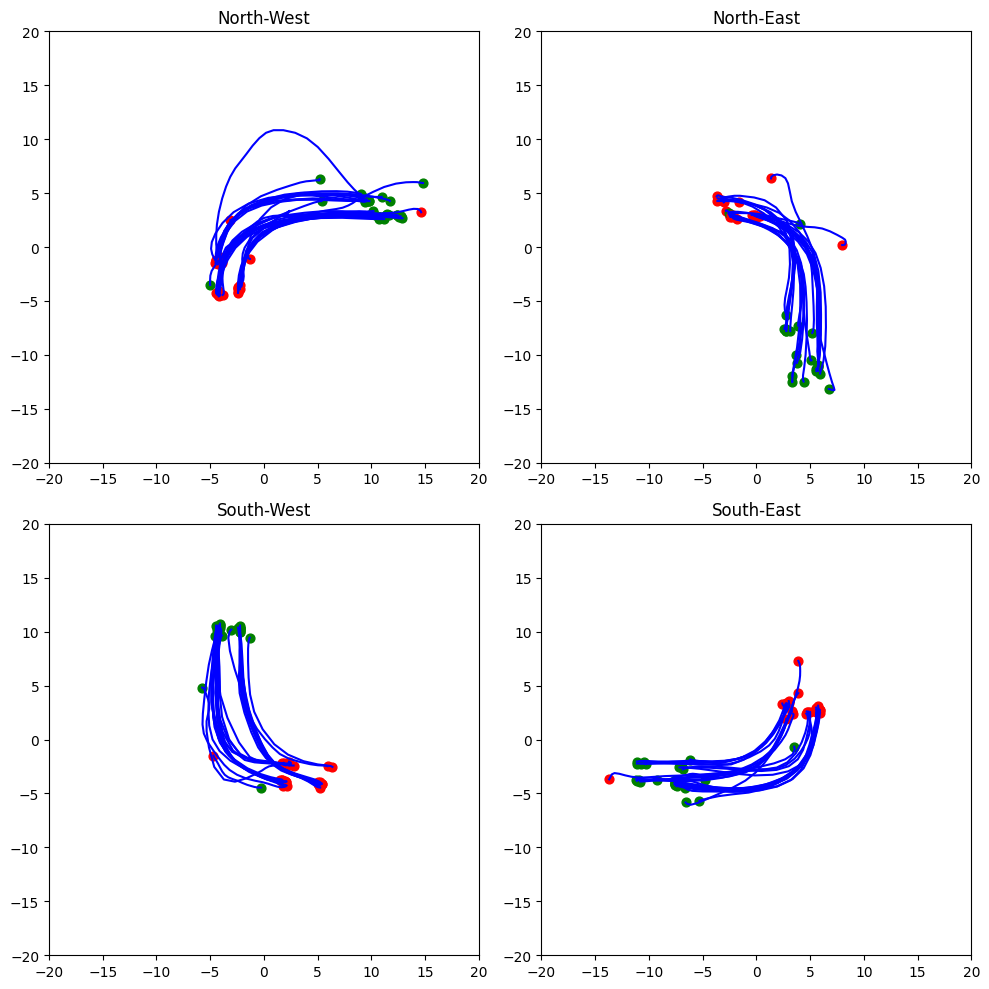

In [ ]:


# Initialize a figure for the 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Titles for the subplots, corresponding to the corners
corners = ['NW', 'NE', 'SW', 'SE']
titles = {'NW': 'North-West', 'NE': 'North-East', 'SW': 'South-West', 'SE': 'South-East'}

# Define which subplot corresponds to each corner (row, col)
corner_to_subplot = {
    'NW': (0, 0),
    'NE': (0, 1),
    'SW': (1, 0),
    'SE': (1, 1)
}

# Plot each set of fixed trajectories, one per corner
for corner in corners:
    ax = axs[corner_to_subplot[corner]]
    
    # Retrieve all trajectories for the current corner
    trajectories = corner_aligned_trajectories[mouse][corner]
    
    # Plot each trajectory on the corresponding subplot
    for trajectory in trajectories:
        ax.plot(trajectory[0, :], trajectory[1, :], color='blue')  # Plot the X and Y coordinates
        ax.scatter(trajectory[0, 0], trajectory[1, 0], color='green', marker='o', edgecolor='green', label='Start Point',s=40)
        ax.scatter(trajectory[0, -1], trajectory[1, -1], color='red', marker='o', edgecolor='red', label='End Point',s=40)    
    
    # Set the title and axis limits
    ax.set_title(titles[corner])
    ax.set_xlim(-20, 20)  # Adjust these limits according to your data
    ax.set_ylim(-20, 20)  # Adjust these limits according to your data

# Remove superfluous spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
assert False, "Stopping execution here." 

AssertionError: Stopping execution here.

In [ ]:
# This cell re-align the trajectory relative to the corner of the tower and then rotate them according to the corner position such as they can all be superposed

def rotate_SWtrajectory_90_ccw(trajectory):
    rotation_matrix = np.array([[0, -1], [1, 0]])
    return rotation_matrix @ trajectory

# Function definitions for rotation (same as before)
def rotate_NWtrajectory_180_ccw(trajectory):
    return -trajectory

def rotate_NEtrajectory_270_ccw(trajectory):
    rotation_matrix = np.array([[0, 1], [-1, 0]])
    return rotation_matrix @ trajectory

realigned_trajectories = []


mice_to_process = [mice_list[0]]
# Initialize the dictionary with empty lists for each mouse
mouse_alltrajectories = {mouse: [] for mouse in mice_to_process}
mouse_alltrajectories_persession = {mouse: {} for mouse in mice_to_process}


trajectories_realigned_rotated = {mouse: [] for mouse in mice_to_process}
trajectories_per_session_realigned_rotated = {mouse: {} for mouse in mice_to_process}

# Initialize trajectories_per_corner_realigned_rotated as an empty dictionary
trajectories_per_corner_realigned_rotated = {}

# Ensure the mouse has a dictionary of corners ('NW', 'NE', 'SE', 'SW')
trajectories_per_corner_realigned_rotated[mouse] = {'NW': [], 'NE': [], 'SE': [], 'SW': []}




for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        print(f'Getting the run trajectory of session {sessionindex}')
        
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exists for session {session_to_process}, skipping .....')
            continue  # Skip loading if the file exists and overwrite is False
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)
            print(session_data['average_speed'])


        # Initialize an entry for the session in the dictionary
        mouse_alltrajectories_persession[mouse][sessionindex] = []
        trajectories_per_session_realigned_rotated[mouse][sessionindex] = []

        runs_around_tower=session_data['all_epochs']['run_around_tower']
        positions=np.array(session_data['positions'])
        for run_around_tower in runs_around_tower:
            if run_around_tower[3]['num_trapezeswitch']==1: # we only take true quarter turns
                run_trajectory=positions[:,run_around_tower[0][0]:run_around_tower[0][1]]
                mouse_alltrajectories[mouse].append(run_trajectory)
                mouse_alltrajectories_persession[mouse][sessionindex].append(run_trajectory)

                # Get the tower and corner names
                tower_name, corner = get_tower_and_corner(run_around_tower)
                
                # Safely access tower and corner coordinates from the dictionary
                if tower_name in clean_towers_coordinates and corner in clean_towers_coordinates[tower_name]:
                    this_corner_coordinates = clean_towers_coordinates[tower_name][corner]
                else:
                    print(f"Invalid tower or corner: {tower_name}, {corner}")
                    continue  # Skip this run if there's an issue
                
                # Extract the trajectory slice based on the start and end time indices
                start_idx, end_idx = run_around_tower[0]  # Assuming it's a list like [8576, 8604]
                this_trajectory = positions[:, start_idx:end_idx]
                
                # Get the corner's reference coordinates (X and Y)
                newXreference = this_corner_coordinates[0]
                newYreference = this_corner_coordinates[1]
                
                # Shift the trajectory to reference the new corner coordinates
                this_trajectory[0, :] -= newXreference  # Shift X coordinates
                this_trajectory[1, :] -= newYreference  # Shift Y coordinates

                #Depending on which corner we are in, we rotate the trajectory accordingly

                if corner == 'SW':
                    this_trajectory = rotate_SWtrajectory_90_ccw(this_trajectory)
                elif corner == 'NW':
                    this_trajectory = rotate_NWtrajectory_180_ccw(this_trajectory)
                elif corner == 'NE':
                    this_trajectory = rotate_NEtrajectory_270_ccw(this_trajectory)
                
                # Append the transformed trajectory to the appropriate corner in corner_aligned_trajectories
                
                trajectories_realigned_rotated[mouse].append(this_trajectory)
                trajectories_per_session_realigned_rotated[mouse][sessionindex].append(this_trajectory)
                trajectories_per_corner_realigned_rotated[mouse][corner].append(this_trajectory)
    







Processing mouse MOUKA271. There is/are 19 sessions to process:
['MOUKA271_20230607-1401', 'MOUKA271_20230608-1053', 'MOUKA271_20230608-1638', 'MOUKA271_20230609-1135', 'MOUKA271_20230609-1706', 'MOUKA271_20230612-1053', 'MOUKA271_20230612-1604', 'MOUKA271_20230613-1011', 'MOUKA271_20230613-1549', 'MOUKA271_20230614-1008', 'MOUKA271_20230614-1551', 'MOUKA271_20230615-1010', 'MOUKA271_20230615-1559', 'MOUKA271_20230616-0944', 'MOUKA271_20230616-1512', 'MOUKA271_20230619-0946', 'MOUKA271_20230619-1514', 'MOUKA271_20230620-0930', 'MOUKA271_20230620-1511'] 

Getting the run trajectory of session 0
9.482164751708822
Getting the run trajectory of session 1
8.32231757809947
Invalid tower or corner: NE, None
Getting the run trajectory of session 2
7.237063794765522
Getting the run trajectory of session 3
9.11088055511185
Getting the run trajectory of session 4
12.231580597841903
Getting the run trajectory of session 5
9.060802610511967
Getting the run trajectory of session 6
11.49606537881955


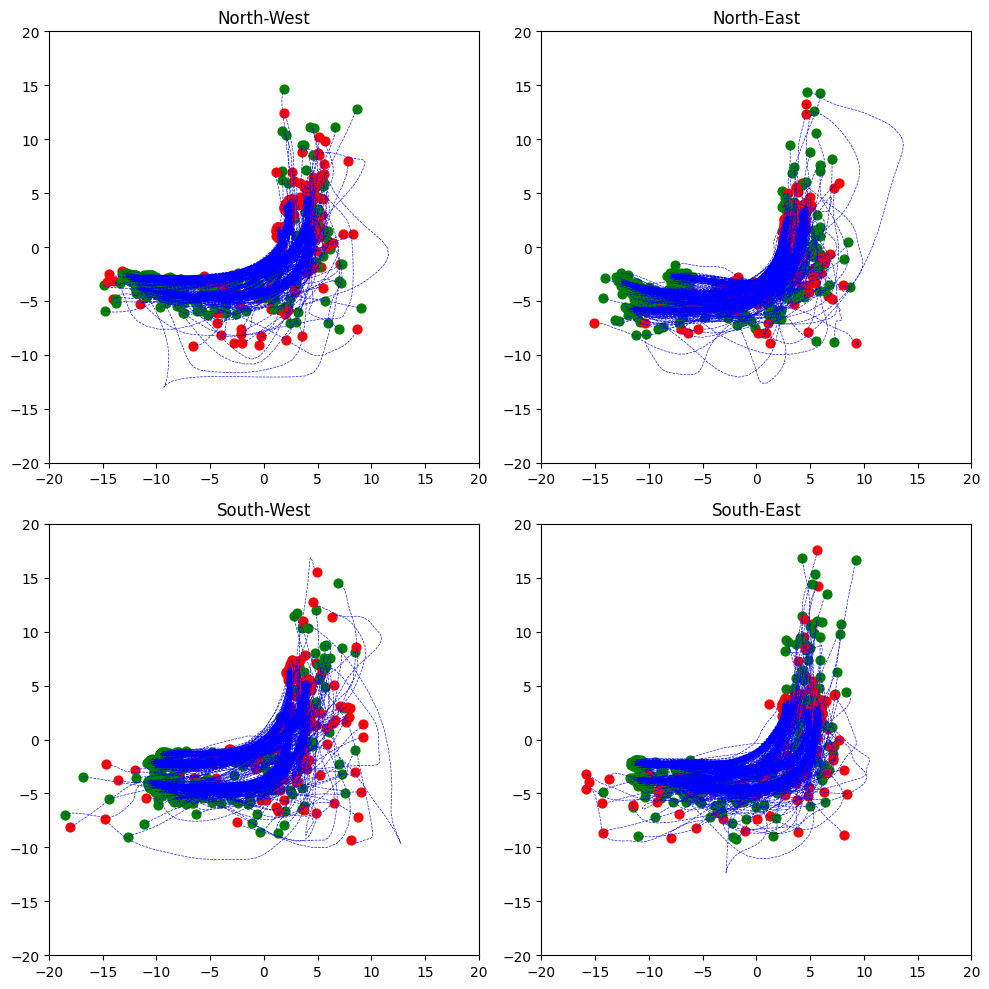

In [ ]:


# Initialize a figure for the 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Titles for the subplots, corresponding to the corners
corners = ['NW', 'NE', 'SW', 'SE']
titles = {'NW': 'North-West', 'NE': 'North-East', 'SW': 'South-West', 'SE': 'South-East'}

# Define which subplot corresponds to each corner (row, col)
corner_to_subplot = {
    'NW': (0, 0),
    'NE': (0, 1),
    'SW': (1, 0),
    'SE': (1, 1)
}

# Plot each set of fixed trajectories, one per corner
for corner in corners:
    ax = axs[corner_to_subplot[corner]]
    
    # Retrieve all trajectories for the current corner
    trajectories = trajectories_per_corner_realigned_rotated[mouse][corner]
    
    # Plot each trajectory on the corresponding subplot
    for trajectory in trajectories:
        
        ax.scatter(trajectory[0, 0], trajectory[1, 0], color='green', marker='o', edgecolor='green', label='Start Point',s=40)
        ax.scatter(trajectory[0, -1], trajectory[1, -1], color='red', marker='o', edgecolor='red', label='End Point',s=40)    
        ax.plot(trajectory[0, :], trajectory[1, :], color='blue', linewidth=0.5,linestyle='dashed', alpha=0.9)  # Plot the X and Y coordinates
    
    # Set the title and axis limits
    ax.set_title(titles[corner])
    ax.set_xlim(-20, 20)  # Adjust these limits according to your data
    ax.set_ylim(-20, 20)  # Adjust these limits according to your data

# Remove superfluous spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# This cell re-aligns the trajectory relative to the corner of the tower and rotates them based on the corner position and direction (CW or CCW).

def rotate_SWtrajectory_90_ccw(trajectory):
    rotation_matrix = np.array([[0, -1], [1, 0]])
    return rotation_matrix @ trajectory

def rotate_NWtrajectory_180_ccw(trajectory):
    return -trajectory

def rotate_NEtrajectory_270_ccw(trajectory):
    rotation_matrix = np.array([[0, 1], [-1, 0]])
    return rotation_matrix @ trajectory

realigned_trajectories = []

mice_to_process = [mice_list[0]]

# Initialize the dictionary with empty lists for each mouse
mouse_alltrajectories = {mouse: [] for mouse in mice_to_process}
mouse_alltrajectories_persession = {mouse: {} for mouse in mice_to_process}

trajectories_realigned_rotated = {mouse: [] for mouse in mice_to_process}
trajectories_per_session_realigned_rotated = {mouse: {} for mouse in mice_to_process}

# Initialize trajectories_per_corner_realigned_rotated as an empty dictionary
# Add another level for direction ('CW' or 'CCW')
trajectories_per_corner_realigned_rotated = {}
for mouse in mice_to_process:
    trajectories_per_corner_realigned_rotated[mouse] = {
        'NW': {'CW': [], 'CCW': []},
        'NE': {'CW': [], 'CCW': []},
        'SE': {'CW': [], 'CCW': []},
        'SW': {'CW': [], 'CCW': []}
    }

for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex, session_to_process in enumerate(sessions_to_process):
        print(f'Getting the run trajectory of session {sessionindex}')
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exist for session {session_to_process}, skipping .....')
            continue
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)
            print(session_data['average_speed'])

        # Initialize an entry for the session in the dictionary
        mouse_alltrajectories_persession[mouse][sessionindex] = []
        trajectories_per_session_realigned_rotated[mouse][sessionindex] = []

        runs_around_tower = session_data['all_epochs']['run_around_tower']
        positions = np.array(session_data['positions'])

        for run_around_tower in runs_around_tower:
            if run_around_tower[3]['num_trapezeswitch'] == 1:  # Only take true quarter turns
                run_trajectory = positions[:, run_around_tower[0][0]:run_around_tower[0][1]]
                mouse_alltrajectories[mouse].append(run_trajectory)
                mouse_alltrajectories_persession[mouse][sessionindex].append(run_trajectory)

                # Get the tower and corner names
                tower_name, corner = get_tower_and_corner(run_around_tower)
                
                # Safely access tower and corner coordinates from the dictionary
                if tower_name in clean_towers_coordinates and corner in clean_towers_coordinates[tower_name]:
                    this_corner_coordinates = clean_towers_coordinates[tower_name][corner]
                else:
                    print(f"Invalid tower or corner: {tower_name}, {corner}")
                    continue
                
                # Extract the trajectory slice based on the start and end time indices
                start_idx, end_idx = run_around_tower[0]  # Assuming it's a list like [8576, 8604]
                this_trajectory = positions[:, start_idx:end_idx]
                
                # Get the corner's reference coordinates (X and Y)
                newXreference = this_corner_coordinates[0]
                newYreference = this_corner_coordinates[1]
                
                # Shift the trajectory to reference the new corner coordinates
                this_trajectory[0, :] -= newXreference  # Shift X coordinates
                this_trajectory[1, :] -= newYreference  # Shift Y coordinates

                # Depending on which corner we are in, rotate the trajectory accordingly
                if corner == 'SW':
                    this_trajectory = rotate_SWtrajectory_90_ccw(this_trajectory)
                elif corner == 'NW':
                    this_trajectory = rotate_NWtrajectory_180_ccw(this_trajectory)
                elif corner == 'NE':
                    this_trajectory = rotate_NEtrajectory_270_ccw(this_trajectory)

                # Get the direction (CW or CCW)
                direction = run_around_tower[3]['direction']

                # Append the transformed trajectory to the appropriate corner and direction
                trajectories_realigned_rotated[mouse].append(this_trajectory)
                trajectories_per_session_realigned_rotated[mouse][sessionindex].append(this_trajectory)
                trajectories_per_corner_realigned_rotated[mouse][corner][direction].append(this_trajectory)


Processing mouse MOUKA271. There is/are 19 sessions to process:
['MOUKA271_20230607-1401', 'MOUKA271_20230608-1053', 'MOUKA271_20230608-1638', 'MOUKA271_20230609-1135', 'MOUKA271_20230609-1706', 'MOUKA271_20230612-1053', 'MOUKA271_20230612-1604', 'MOUKA271_20230613-1011', 'MOUKA271_20230613-1549', 'MOUKA271_20230614-1008', 'MOUKA271_20230614-1551', 'MOUKA271_20230615-1010', 'MOUKA271_20230615-1559', 'MOUKA271_20230616-0944', 'MOUKA271_20230616-1512', 'MOUKA271_20230619-0946', 'MOUKA271_20230619-1514', 'MOUKA271_20230620-0930', 'MOUKA271_20230620-1511'] 

Getting the run trajectory of session 0
9.482164751708822
Getting the run trajectory of session 1
8.32231757809947
Invalid tower or corner: NE, None
Getting the run trajectory of session 2
7.237063794765522
Getting the run trajectory of session 3
9.11088055511185
Getting the run trajectory of session 4
12.231580597841903
Getting the run trajectory of session 5
9.060802610511967
Getting the run trajectory of session 6
11.49606537881955


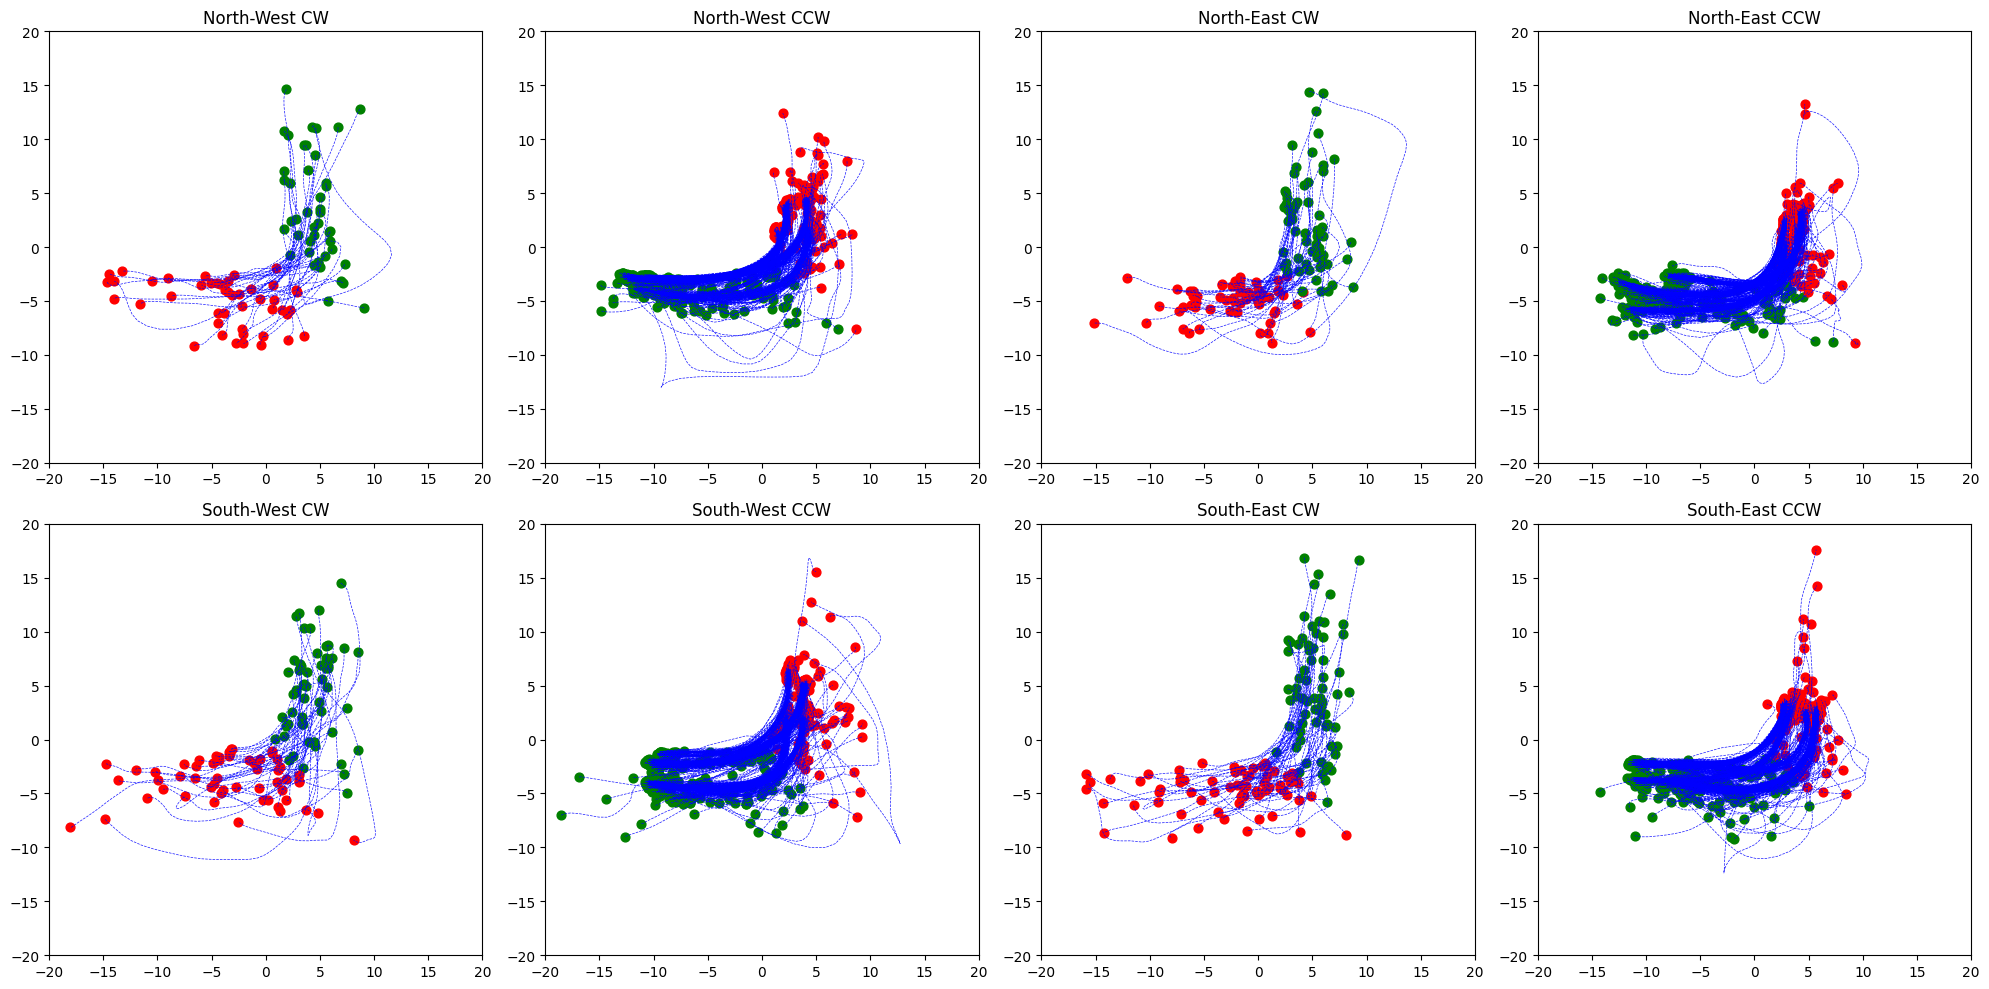

In [ ]:
# Initialize a figure for the 2x4 subplot grid
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns

# Titles for the subplots, corresponding to the corners and directions
corners = ['NW', 'NE', 'SW', 'SE']
directions = ['CW', 'CCW']
titles = {
    'NW': {'CW': 'North-West CW', 'CCW': 'North-West CCW'},
    'NE': {'CW': 'North-East CW', 'CCW': 'North-East CCW'},
    'SW': {'CW': 'South-West CW', 'CCW': 'South-West CCW'},
    'SE': {'CW': 'South-East CW', 'CCW': 'South-East CCW'}
}

# Define which subplot corresponds to each corner and direction (row, col)
corner_direction_to_subplot = {
    'NW': {'CW': (0, 0), 'CCW': (0, 1)},
    'NE': {'CW': (0, 2), 'CCW': (0, 3)},
    'SW': {'CW': (1, 0), 'CCW': (1, 1)},
    'SE': {'CW': (1, 2), 'CCW': (1, 3)}
}

# Plot each set of fixed trajectories, separately for CW and CCW
for corner in corners:
    for direction in directions:
        # Determine the correct subplot based on corner and direction
        row, col = corner_direction_to_subplot[corner][direction]
        ax = axs[row, col]
        
        # Retrieve the trajectories for the current corner and direction
        trajectories = trajectories_per_corner_realigned_rotated[mouse][corner][direction]
        
        # Plot each trajectory on the corresponding subplot
        for trajectory in trajectories:
            ax.scatter(trajectory[0, 0], trajectory[1, 0], color='green', marker='o', edgecolor='green', label='Start Point', s=40)
            ax.scatter(trajectory[0, -1], trajectory[1, -1], color='red', marker='o', edgecolor='red', label='End Point', s=40)
            ax.plot(trajectory[0, :], trajectory[1, :], color='blue', linewidth=0.5, linestyle='dashed', alpha=0.9)  # Plot the X and Y coordinates
        
        # Set the title and axis limits
        ax.set_title(titles[corner][direction])
        ax.set_xlim(-20, 20)  # Adjust these limits according to your data
        ax.set_ylim(-20, 20)  # Adjust these limits according to your data

# Remove superfluous spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# This cell re-aligns the trajectory relative to the corner of the tower and rotates them based on the corner position and direction (CW or CCW).

def rotate_SWtrajectory_90_ccw(trajectory):
    rotation_matrix = np.array([[0, -1], [1, 0]])
    return rotation_matrix @ trajectory

def rotate_NWtrajectory_180_ccw(trajectory):
    return -trajectory

def rotate_NEtrajectory_270_ccw(trajectory):
    rotation_matrix = np.array([[0, 1], [-1, 0]])
    return rotation_matrix @ trajectory

realigned_trajectories = []

mice_to_process = [mice_list[0]]

# Initialize the dictionary with empty lists for each mouse
mouse_alltrajectories = {mouse: [] for mouse in mice_to_process}
mouse_alltrajectories_persession = {mouse: {} for mouse in mice_to_process}

trajectories_realigned_rotated = {mouse: [] for mouse in mice_to_process}
trajectories_per_session_realigned_rotated = {mouse: {} for mouse in mice_to_process}



for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex, session_to_process in enumerate(sessions_to_process):
        print(f'Getting the run trajectory of session {sessionindex}')
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exist for session {session_to_process}, skipping .....')
            continue
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)
            print(session_data['average_speed'])

        # Initialize an entry for the session in the dictionary
        mouse_alltrajectories_persession[mouse][sessionindex] = []
        trajectories_per_session_realigned_rotated[mouse][sessionindex] = {'CW':[], 'CCW':[]}

        runs_around_tower = session_data['all_epochs']['run_around_tower']
        positions = np.array(session_data['positions'])

        for run_around_tower in runs_around_tower:
            if run_around_tower[3]['num_trapezeswitch'] == 1:  # Only take true quarter turns
                run_trajectory = positions[:, run_around_tower[0][0]:run_around_tower[0][1]]
                mouse_alltrajectories[mouse].append(run_trajectory)
                mouse_alltrajectories_persession[mouse][sessionindex].append(run_trajectory)

                # Get the tower and corner names
                tower_name, corner = get_tower_and_corner(run_around_tower)
                
                # Safely access tower and corner coordinates from the dictionary
                if tower_name in clean_towers_coordinates and corner in clean_towers_coordinates[tower_name]:
                    this_corner_coordinates = clean_towers_coordinates[tower_name][corner]
                else:
                    print(f"Invalid tower or corner: {tower_name}, {corner}")
                    continue
                
                # Extract the trajectory slice based on the start and end time indices
                start_idx, end_idx = run_around_tower[0]  # Assuming it's a list like [8576, 8604]
                this_trajectory = positions[:, start_idx:end_idx]
                
                # Get the corner's reference coordinates (X and Y)
                newXreference = this_corner_coordinates[0]
                newYreference = this_corner_coordinates[1]
                
                # Shift the trajectory to reference the new corner coordinates
                this_trajectory[0, :] -= newXreference  # Shift X coordinates
                this_trajectory[1, :] -= newYreference  # Shift Y coordinates

                # Depending on which corner we are in, rotate the trajectory accordingly
                if corner == 'SW':
                    this_trajectory = rotate_SWtrajectory_90_ccw(this_trajectory)
                elif corner == 'NW':
                    this_trajectory = rotate_NWtrajectory_180_ccw(this_trajectory)
                elif corner == 'NE':
                    this_trajectory = rotate_NEtrajectory_270_ccw(this_trajectory)

                # Get the direction (CW or CCW)
                direction = run_around_tower[3]['direction']

                # Append the transformed trajectory to the appropriate corner and direction
                trajectories_realigned_rotated[mouse].append(this_trajectory)
                trajectories_per_session_realigned_rotated[mouse][sessionindex][direction].append(this_trajectory)
                #trajectories_per_corner_realigned_rotated[mouse][corner][direction].append(this_trajectory)


Processing mouse MOUKA271. There is/are 19 sessions to process:
['MOUKA271_20230607-1401', 'MOUKA271_20230608-1053', 'MOUKA271_20230608-1638', 'MOUKA271_20230609-1135', 'MOUKA271_20230609-1706', 'MOUKA271_20230612-1053', 'MOUKA271_20230612-1604', 'MOUKA271_20230613-1011', 'MOUKA271_20230613-1549', 'MOUKA271_20230614-1008', 'MOUKA271_20230614-1551', 'MOUKA271_20230615-1010', 'MOUKA271_20230615-1559', 'MOUKA271_20230616-0944', 'MOUKA271_20230616-1512', 'MOUKA271_20230619-0946', 'MOUKA271_20230619-1514', 'MOUKA271_20230620-0930', 'MOUKA271_20230620-1511'] 

Getting the run trajectory of session 0
9.482164751708822
Getting the run trajectory of session 1
8.32231757809947
Invalid tower or corner: NE, None
Getting the run trajectory of session 2
7.237063794765522
Getting the run trajectory of session 3
9.11088055511185
Getting the run trajectory of session 4
12.231580597841903
Getting the run trajectory of session 5
9.060802610511967
Getting the run trajectory of session 6
11.49606537881955


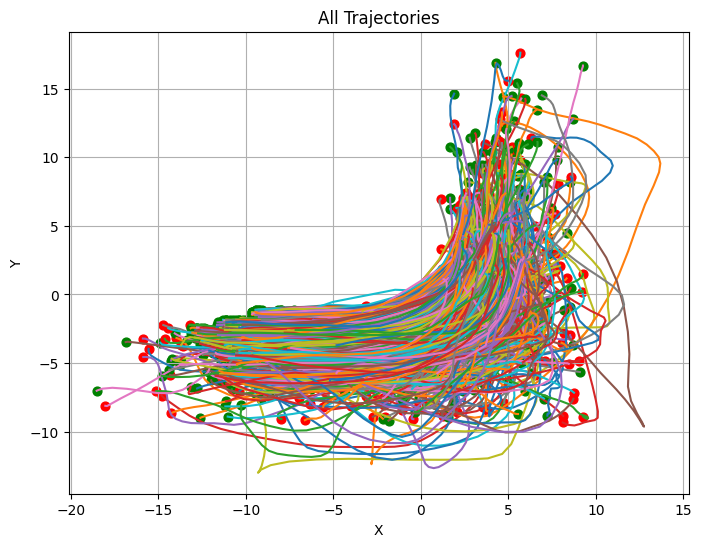

In [ ]:
plot_trajectories(trajectories_realigned_rotated['MOUKA271'],marker='')

In [ ]:
length_all_trajectories=[]
for trajectory in trajectories_realigned_rotated['MOUKA271']:
    length_all_trajectories.append(trajectory.shape[1])

print(np.median(length_all_trajectories))

23.0


In [ ]:
def resample_trajectory(trajectory, target_size):
    """
    Resample a single trajectory to have the target number of points.
    
    Parameters:
        trajectory (np.ndarray): A 2D numpy array of shape (2, X).
        target_size (int): The target number of points (X).
        
    Returns:
        np.ndarray: A 2D numpy array of shape (2, target_size).
    """
    # Get current number of points
    current_size = trajectory.shape[1]
    
    # Create an array of indices for the original points and the target points
    original_indices = np.linspace(0, current_size - 1, num=current_size)
    target_indices = np.linspace(0, current_size - 1, num=target_size)
    
    # Resample by interpolating the trajectory for each row (x and y coordinates)
    resampled_trajectory = np.array([np.interp(target_indices, original_indices, trajectory[i, :])
                                     for i in range(2)])
    
    return resampled_trajectory

def resample_all_trajectories(all_trajectories, target_size):
    """
    Resample all trajectories to have the same target number of points.
    
    Parameters:
        all_trajectories (list): A list of 2D numpy arrays of shape (2, X).
        target_size (int): The target number of points for each trajectory.
        
    Returns:
        list: A list of resampled 2D numpy arrays of shape (2, target_size).
    """
    resampled_trajectories = [resample_trajectory(trajectory, target_size) for trajectory in all_trajectories]
    return resampled_trajectories


In [ ]:
def resample_trajectory(trajectory, target_size):
    """
    Resample a single trajectory to have the target number of points.
    
    Parameters:
        trajectory (np.ndarray): A 2D numpy array of shape (2, X).
        target_size (int): The target number of points (X).
        
    Returns:
        np.ndarray: A 2D numpy array of shape (2, target_size).
    """
    # Get current number of points
    current_size = trajectory.shape[1]
    
    # Create an array of indices for the original points and the target points
    original_indices = np.linspace(0, current_size - 1, num=current_size)
    target_indices = np.linspace(0, current_size - 1, num=target_size)
    
    # Resample by interpolating the trajectory for each row (x and y coordinates)
    resampled_trajectory = np.array([np.interp(target_indices, original_indices, trajectory[i, :])
                                     for i in range(2)])
    
    return resampled_trajectory

def resample_all_trajectories(all_trajectories, target_size):
    """
    Resample all trajectories to have the same target number of points.
    
    Parameters:
        all_trajectories (list): A list of 2D numpy arrays of shape (2, X).
        target_size (int): The target number of points for each trajectory.
        
    Returns:
        list: A list of resampled 2D numpy arrays of shape (2, target_size).
    """
    resampled_trajectories = [resample_trajectory(trajectory, target_size) for trajectory in all_trajectories]
    return resampled_trajectories


In [ ]:
def compute_pairwise_correlations(trajectories):
    """Compute pairwise correlations between trajectories."""
    num_trajectories = len(trajectories)
    print(f"Number of trajectories: {num_trajectories}")
    correlations = []
    
    for i in range(num_trajectories):
        for j in range(i + 1, num_trajectories):
            traj1 = trajectories[i]
            #print(len(traj1))
            traj2 = trajectories[j]
            #print(len(traj2))
            
            # Flatten trajectories for correlation computation
            traj1_flat = traj1.flatten()
            #print(len(traj1_flat))
            traj2_flat = traj2.flatten()
            #print(len(traj2_flat))
            
            # Compute correlation coefficient
            corr = np.corrcoef(traj1_flat, traj2_flat)[0, 1]
            correlations.append(corr)
    
    return correlations

Processing session index: 0
24
Processing session index: 1
45
Processing session index: 2
58
Processing session index: 3
67
Processing session index: 4
163
Processing session index: 5
60
Processing session index: 6
121
Processing session index: 7
89
Processing session index: 8
119
Processing session index: 9
99
Processing session index: 10
148
Processing session index: 11
133
Processing session index: 12
190
Processing session index: 13
133
Processing session index: 14
148
Processing session index: 15
55
Processing session index: 16
43
Processing session index: 17
77
Processing session index: 18
112


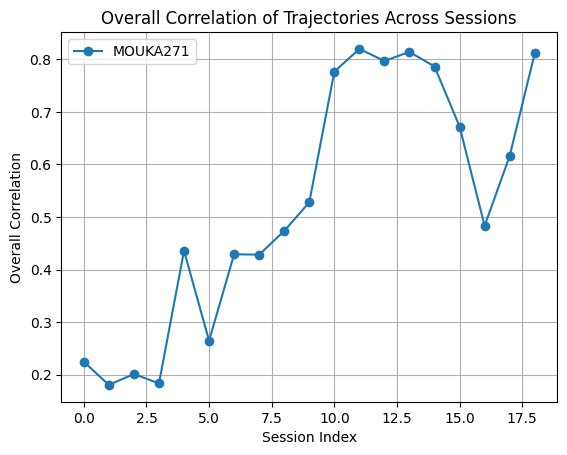

In [ ]:
overall_correlations_per_session = {mouse: [] for mouse in trajectories_per_session_realigned_rotated}


for session_index in trajectories_per_session_realigned_rotated[mouse]:
        print(f"Processing session index: {session_index}")
        
        # Access the realigned trajectories for the current session
        realigned_trajectories = trajectories_per_session_realigned_rotated[mouse][session_index]
        resampled_realigned_trajectories=resample_all_trajectories(realigned_trajectories, 23)
        # Compute pairwise correlations for the session
        correlations = compute_pairwise_correlations(resampled_realigned_trajectories)
        
        # Compute the overall correlation (mean of pairwise correlations)
        overall_correlation = np.mean(correlations)
        
        # Store the overall correlation
        overall_correlations_per_session[mouse].append(overall_correlation)

# Plotting the overall correlations across sessions
for mouse in overall_correlations_per_session:
    session_indices = list(range(len(overall_correlations_per_session[mouse])))
    correlations = overall_correlations_per_session[mouse]
    
    plt.plot(session_indices, correlations, marker='o', label=mouse)

plt.xlabel('Session Index')
plt.ylabel('Overall Correlation')
plt.title('Overall Correlation of Trajectories Across Sessions')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
trajectories_per_session_realigned_rotated[mouse][sessionindex][direction].append(this_trajectory)

In [ ]:
type(realigned_trajectories)

list

Processing session index: 0 for direction: CW
Number of trajectories: 13
Processing session index: 1 for direction: CW
Number of trajectories: 28
Processing session index: 2 for direction: CW
Number of trajectories: 19
Processing session index: 3 for direction: CW
Number of trajectories: 23
Processing session index: 4 for direction: CW
Number of trajectories: 27
Processing session index: 5 for direction: CW
Number of trajectories: 15
Processing session index: 6 for direction: CW
Number of trajectories: 21
Processing session index: 7 for direction: CW
Number of trajectories: 14
Processing session index: 8 for direction: CW
Number of trajectories: 17
Processing session index: 9 for direction: CW
Number of trajectories: 12
Processing session index: 10 for direction: CW
Number of trajectories: 5
Processing session index: 11 for direction: CW
Number of trajectories: 2
Processing session index: 12 for direction: CW
Number of trajectories: 7
Processing session index: 13 for direction: CW
Numb

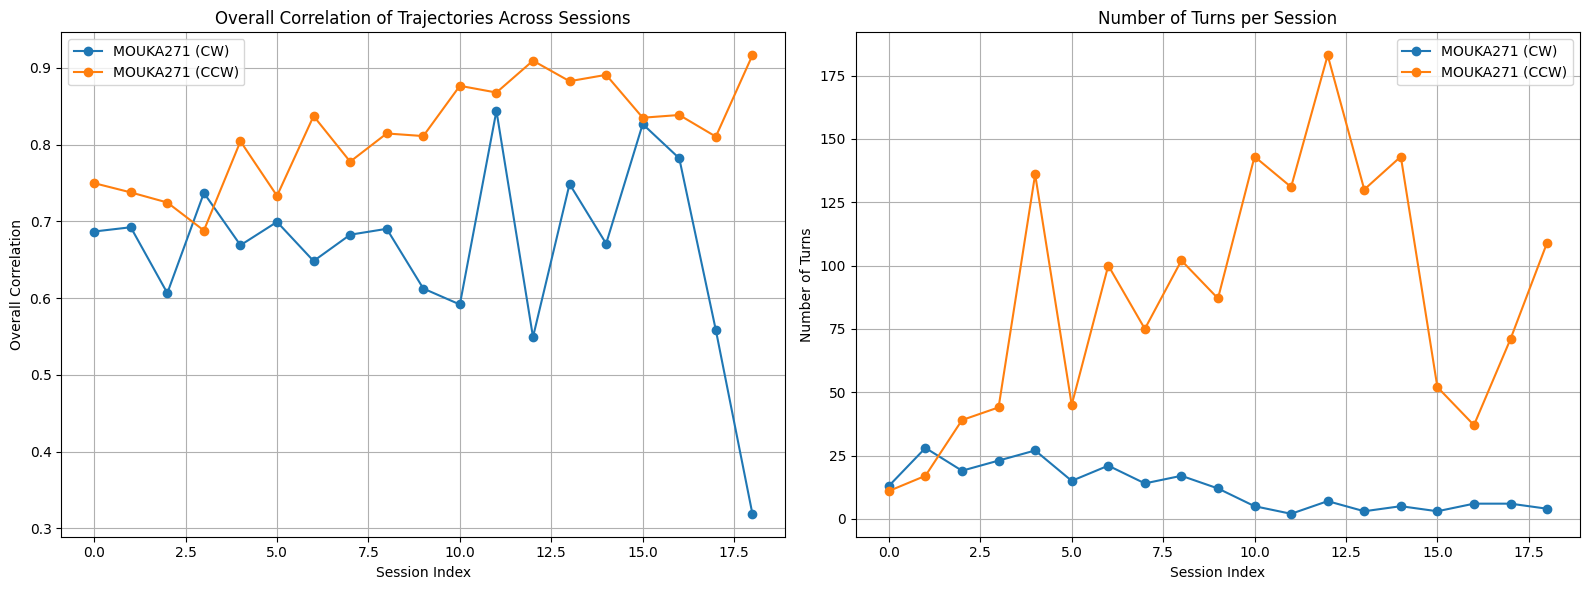

In [ ]:
# Initialize dictionaries to store overall correlations per session for each direction
overall_correlations_per_session = {mouse: {'CW': [], 'CCW': []} for mouse in trajectories_per_session_realigned_rotated}
numberof_turns_per_session = {mouse: {'CW': [], 'CCW': []} for mouse in trajectories_per_session_realigned_rotated}
# Directions to process
directions = ['CW', 'CCW']

# Loop through each direction (CW and CCW)
for direction in directions:
    for session_index in trajectories_per_session_realigned_rotated[mouse]:
        print(f"Processing session index: {session_index} for direction: {direction}")
        
        # Access the realigned trajectories for the current session and direction
        realigned_trajectories = trajectories_per_session_realigned_rotated[mouse][session_index][direction]
        
        if not realigned_trajectories:
            print(f"No trajectories for {direction} in session {session_index}, skipping...")
            continue
        
        # Resample the trajectories to a fixed length (23)
        resampled_realigned_trajectories = resample_all_trajectories(realigned_trajectories, 23)
        
        # Compute pairwise correlations for the session
        correlations = compute_pairwise_correlations(resampled_realigned_trajectories)
        
        # Compute the overall correlation (mean of pairwise correlations)
        overall_correlation = np.mean(correlations)
        
        # Store the overall correlation for the current direction
        overall_correlations_per_session[mouse][direction].append(overall_correlation)
        numberof_turns_per_session[mouse][direction].append(len(realigned_trajectories))

# Plotting the overall correlations across sessions for CW and CCW separately

fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Define labels and titles for each subplot
x_labels = ['Session Index', 'Session Index']
y_labels = ['Overall Correlation', 'Number of Turns']
titles = ['Overall Correlation of Trajectories Across Sessions', 'Number of Turns per Session']

for direction in directions:
    # Plot the overall correlations for each mouse for the current direction
    for mouse in overall_correlations_per_session:
        session_indices = list(range(len(overall_correlations_per_session[mouse][direction])))
        correlations = overall_correlations_per_session[mouse][direction]
        turns_per_session = numberof_turns_per_session[mouse][direction]

        axs[0].plot(session_indices, correlations, marker='o', label=f"{mouse} ({direction})")
        axs[1].plot(session_indices, turns_per_session, marker='o', label=f"{mouse} ({direction})")

# Loop over the subplots and set the labels and titles
for i, ax in enumerate(axs):
    ax.set_xlabel(x_labels[i])
    ax.set_ylabel(y_labels[i])
    ax.set_title(titles[i])
    ax.legend()
    ax.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()



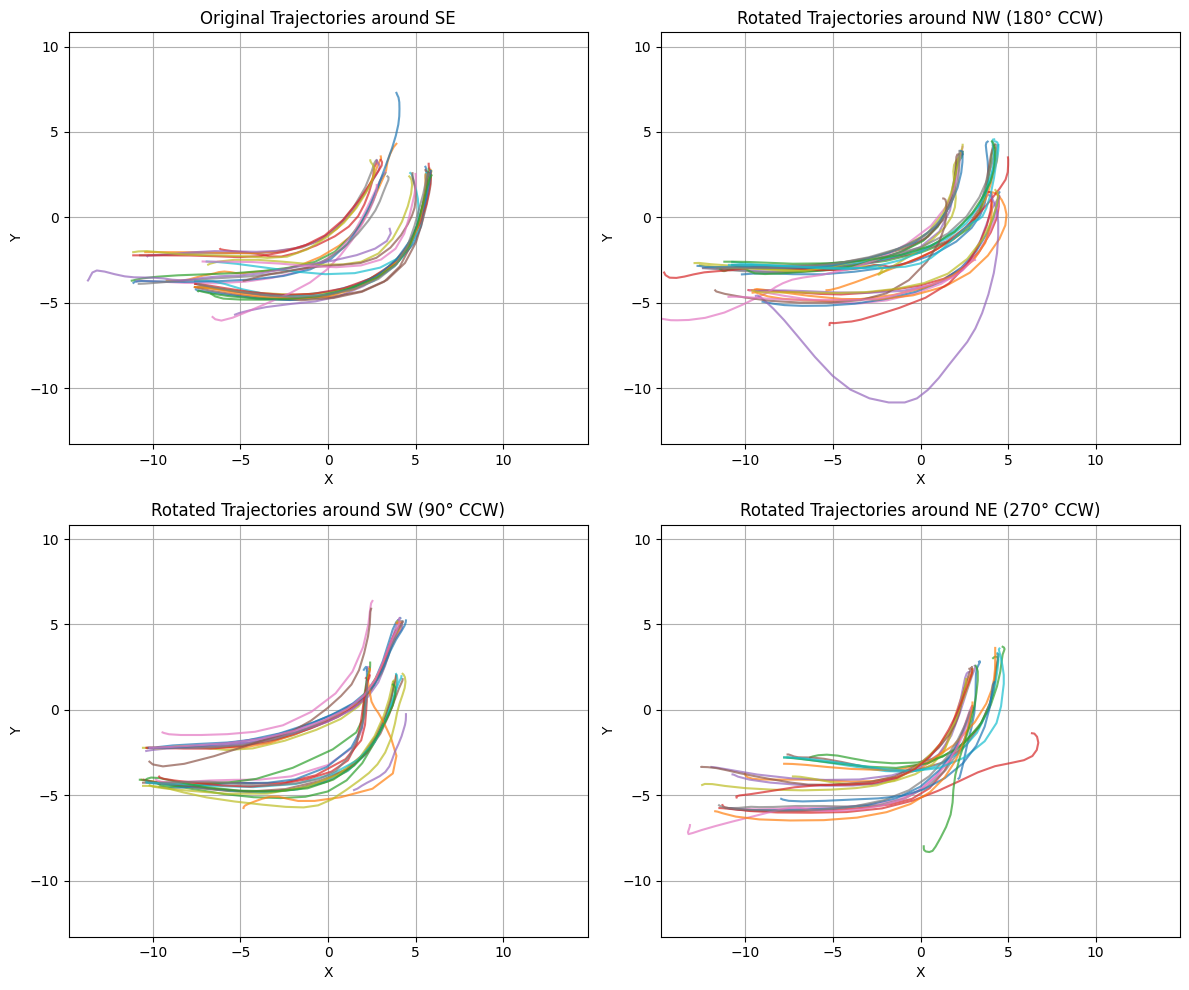

In [ ]:

# Initialize rotated_trajectories with the same structure as corner_aligned_trajectories
rotated_trajectories = {}
rotated_trajectories[mouse] = {'NW': [], 'NE': [], 'SE': [], 'SW': []}



def rotate_SWtrajectory_90_ccw(trajectory):
    rotation_matrix = np.array([[0, -1], [1, 0]])
    return rotation_matrix @ trajectory

# Function definitions for rotation (same as before)
def rotate_NWtrajectory_180_ccw(trajectory):
    return -trajectory

def rotate_NEtrajectory_270_ccw(trajectory):
    rotation_matrix = np.array([[0, 1], [-1, 0]])
    return rotation_matrix @ trajectory

# Rotate trajectories for each corner (same as before)
for i in range(len(corner_aligned_trajectories[mouse]['NW'])):
    this_trajectory = corner_aligned_trajectories[mouse]['NW'][i]
    rotated_trajectory = rotate_NWtrajectory_180_ccw(this_trajectory)
    rotated_trajectories[mouse]['NW'].append(rotated_trajectory)

for i in range(len(corner_aligned_trajectories[mouse]['SW'])):
    this_trajectory = corner_aligned_trajectories[mouse]['SW'][i]
    rotated_trajectory = rotate_SWtrajectory_90_ccw(this_trajectory)
    rotated_trajectories[mouse]['SW'].append(rotated_trajectory)

for i in range(len(corner_aligned_trajectories[mouse]['NE'])):
    this_trajectory = corner_aligned_trajectories[mouse]['NE'][i]
    rotated_trajectory = rotate_NEtrajectory_270_ccw(this_trajectory)
    rotated_trajectories[mouse]['NE'].append(rotated_trajectory)

# Determine consistent x and y limits
all_trajectories = []
for corner in ['SE', 'NW', 'SW', 'NE']:
    for trajectory in corner_aligned_trajectories[mouse].get(corner, []):
        all_trajectories.append(trajectory)
    for trajectory in rotated_trajectories[mouse].get(corner, []):
        all_trajectories.append(trajectory)

all_x = np.concatenate([trajectory[0, :] for trajectory in all_trajectories])
all_y = np.concatenate([trajectory[1, :] for trajectory in all_trajectories])

x_lim = (min(all_x), max(all_x))
y_lim = (min(all_y), max(all_y))

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

# Plot Original Trajectories around SE
for trajectory in corner_aligned_trajectories[mouse]['SE']:
    axs[0].plot(trajectory[0, :], trajectory[1, :], alpha=0.7)
axs[0].set_title('Original Trajectories around SE')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_xlim(x_lim)
axs[0].set_ylim(y_lim)
axs[0].grid(True)

# Plot Rotated Trajectories around NW (180° CCW)
for trajectory in rotated_trajectories[mouse]['NW']:
    axs[1].plot(trajectory[0, :], trajectory[1, :], alpha=0.7)
axs[1].set_title('Rotated Trajectories around NW (180° CCW)')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_xlim(x_lim)
axs[1].set_ylim(y_lim)
axs[1].grid(True)

# Plot Rotated Trajectories around SW (90° CCW)
for trajectory in rotated_trajectories[mouse]['SW']:
    axs[2].plot(trajectory[0, :], trajectory[1, :], alpha=0.7)
axs[2].set_title('Rotated Trajectories around SW (90° CCW)')
axs[2].set_xlabel('X')
axs[2].set_ylabel('Y')
axs[2].set_xlim(x_lim)
axs[2].set_ylim(y_lim)
axs[2].grid(True)

# Plot Rotated Trajectories around NE (270° CCW)
for trajectory in rotated_trajectories[mouse]['NE']:
    axs[3].plot(trajectory[0, :], trajectory[1, :], alpha=0.7)
axs[3].set_title('Rotated Trajectories around NE (270° CCW)')
axs[3].set_xlabel('X')
axs[3].set_ylabel('Y')
axs[3].set_xlim(x_lim)
axs[3].set_ylim(y_lim)
axs[3].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
mice_to_process = [mice_list[0]]
# Initialize the dictionary with empty lists for each mouse

for mouse in mice_to_process:
    CCWturns_ratio_accross_sessions=[]
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        print(f'Getting the run trajectory of session {session_to_process}')
        
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exists for session {session_to_process}, skipping .....')
            continue  # Skip loading if the file exists and overwrite is False
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)
            print(session_data['run_around_tower_sessionresult'])

        run_around_tower_sessionresult=session_data['run_around_tower_sessionresult']
        thissessionCCWratio=run_around_tower_sessionresult['All']['total_CCW']/(run_around_tower_sessionresult['All']['total_CCW']+run_around_tower_sessionresult['All']['total_CW'])

        CCWturns_ratio_accross_sessions.append(thissessionCCWratio)


        
        # Run the processing if file doesn't exist or overwrite is True
        

Processing mouse MOUKA271. There is/are 19 sessions to process:
['MOUKA271_20230607-1401', 'MOUKA271_20230608-1053', 'MOUKA271_20230608-1638', 'MOUKA271_20230609-1135', 'MOUKA271_20230609-1706', 'MOUKA271_20230612-1053', 'MOUKA271_20230612-1604', 'MOUKA271_20230613-1011', 'MOUKA271_20230613-1549', 'MOUKA271_20230614-1008', 'MOUKA271_20230614-1551', 'MOUKA271_20230615-1010', 'MOUKA271_20230615-1559', 'MOUKA271_20230616-0944', 'MOUKA271_20230616-1512', 'MOUKA271_20230619-0946', 'MOUKA271_20230619-1514', 'MOUKA271_20230620-0930', 'MOUKA271_20230620-1511'] 

Getting the run trajectory of session MOUKA271_20230607-1401
{'NE': {'total_CW': 5, 'total_CCW': 3, 'rewarded_CW': 0, 'rewarded_CCW': 3}, 'NW': {'total_CW': 3, 'total_CCW': 1, 'rewarded_CW': 0, 'rewarded_CCW': 0}, 'SE': {'total_CW': 4, 'total_CCW': 4, 'rewarded_CW': 0, 'rewarded_CCW': 0}, 'SW': {'total_CW': 1, 'total_CCW': 5, 'rewarded_CW': 0, 'rewarded_CCW': 0}, 'All': {'total_CW': 13, 'total_CCW': 13, 'rewarded_CW': 0, 'rewarded_CCW'

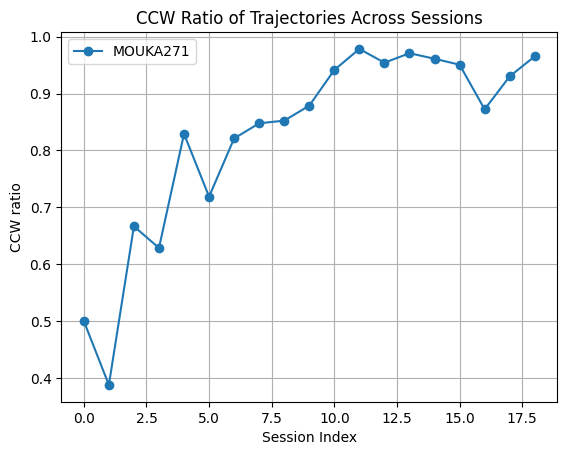

In [ ]:
plt.plot(session_indices, CCWturns_ratio_accross_sessions, marker='o', label=mouse)

plt.xlabel('Session Index')
plt.ylabel('CCW ratio')
plt.title('CCW Ratio of Trajectories Across Sessions')
plt.legend()
plt.grid(True)
plt.show()




# Playing with PCA

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

def apply_pca_to_trajectory(trajectory, n_components=2):
    """
    Apply PCA to a single trajectory and return the first two principal components.
    
    Parameters:
        trajectory (np.ndarray): A 2D numpy array of shape (2, X).
        n_components (int): Number of principal components to keep.
        
    Returns:
        np.ndarray: A 2D numpy array of the transformed trajectory in the space of the first two PCs.
    """
    # Transpose trajectory to have shape (X, 2) for PCA input
    trajectory_t = trajectory.T
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    transformed_trajectory = pca.fit_transform(trajectory_t)
    
    return transformed_trajectory

def apply_pca_to_all_trajectories(trajectories, n_components=2):
    """
    Apply PCA to all trajectories and extract the first two principal components.
    
    Parameters:
        trajectories (list): A list of 2D numpy arrays of shape (2, X).
        n_components (int): Number of principal components to keep.
        
    Returns:
        list: A list of transformed trajectories in the space of the first two PCs.
    """
    transformed_trajectories = [apply_pca_to_trajectory(traj, n_components) for traj in trajectories]
    return transformed_trajectories


In [ ]:
# Apply PCA to the resampled trajectories
pca_transformed_trajectories = apply_pca_to_all_trajectories(resampled_trajectories)

# Print the first two principal components of each trajectory
for idx, traj in enumerate(pca_transformed_trajectories):
    print(f"Trajectory {idx + 1} (first two PCs):\n{traj}\n")


Trajectory 1 (first two PCs):
[[-7.10350967 -1.35893374]
 [-6.97518037 -1.1101479 ]
 [-6.71691929 -0.77492688]
 [-6.35163586 -0.37151231]
 [-5.94443658 -0.02350473]
 [-5.46990467  0.20404212]
 [-4.87818112  0.33603757]
 [-4.28347187  0.45216335]
 [-3.73004398  0.57956695]
 [-3.09623533  0.71465983]
 [-2.29967975  0.82099186]
 [-1.36818285  0.79319402]
 [-0.25347784  0.6368385 ]
 [ 1.08362544  0.51042972]
 [ 2.66906364  0.4302572 ]
 [ 4.30908336  0.25850649]
 [ 5.6629758  -0.0203514 ]
 [ 6.58584846 -0.23707106]
 [ 7.13921941 -0.34638237]
 [ 7.47632568 -0.40276758]
 [ 7.74039024 -0.41599689]
 [ 7.90026499 -0.36683591]
 [ 7.90406216 -0.30825684]]

Trajectory 2 (first two PCs):
[[ 6.61569663 -1.55152724]
 [ 6.54456965 -1.45560138]
 [ 6.50929009 -1.25547213]
 [ 6.3821611  -0.98156366]
 [ 6.04734071 -0.66040218]
 [ 5.53344521 -0.29855447]
 [ 4.94946352  0.09512926]
 [ 4.30496797  0.50082024]
 [ 3.58699803  0.88351468]
 [ 2.8036971   1.24768561]
 [ 1.91330577  1.59405559]
 [ 0.86183753  1.848

In [ ]:
pca_transformed_trajectories[0]

array([[-7.10350967, -1.35893374],
       [-6.97518037, -1.1101479 ],
       [-6.71691929, -0.77492688],
       [-6.35163586, -0.37151231],
       [-5.94443658, -0.02350473],
       [-5.46990467,  0.20404212],
       [-4.87818112,  0.33603757],
       [-4.28347187,  0.45216335],
       [-3.73004398,  0.57956695],
       [-3.09623533,  0.71465983],
       [-2.29967975,  0.82099186],
       [-1.36818285,  0.79319402],
       [-0.25347784,  0.6368385 ],
       [ 1.08362544,  0.51042972],
       [ 2.66906364,  0.4302572 ],
       [ 4.30908336,  0.25850649],
       [ 5.6629758 , -0.0203514 ],
       [ 6.58584846, -0.23707106],
       [ 7.13921941, -0.34638237],
       [ 7.47632568, -0.40276758],
       [ 7.74039024, -0.41599689],
       [ 7.90026499, -0.36683591],
       [ 7.90406216, -0.30825684]])

In [ ]:
def prepare_data_for_pca(trajectories):
    """
    Flatten each trajectory and combine them into a single dataset for PCA.
    
    Parameters:
        trajectories (list): A list of 2D numpy arrays where each array has shape (2, 20).
        
    Returns:
        np.ndarray: A 2D numpy array where each row represents a flattened trajectory.
    """
    # Flatten each trajectory and stack them into a single matrix
    flattened_trajectories = [traj.flatten() for traj in trajectories]
    combined_data = np.array(flattened_trajectories)
    return combined_data

In [ ]:
combined_data=prepare_data_for_pca(resampled_trajectories)

In [ ]:
import matplotlib.cm as cm
def apply_pca(combined_data, n_components=2):
    """
    Apply PCA to the combined dataset.
    
    Parameters:
        combined_data (np.ndarray): The dataset to apply PCA to.
        n_components (int): Number of principal components to keep.
        
    Returns:
        PCA: Fitted PCA object.
        np.ndarray: The transformed data in PCA space.
    """
    pca = PCA(n_components=n_components)
    pca_transformed = pca.fit_transform(combined_data)
    return pca, pca_transformed

def transform_trajectory(pca, trajectory):
    """
    Transform a single trajectory into the PCA space.
    
    Parameters:
        pca (PCA): Fitted PCA object.
        trajectory (np.ndarray): A 2D numpy array of shape (2, 20).
        
    Returns:
        np.ndarray: The transformed trajectory in PCA space.
    """
    trajectory_flattened = trajectory.flatten().reshape(1, -1)
    transformed_trajectory = pca.transform(trajectory_flattened)
    return transformed_trajectory

def plot_pca_trajectories(pca_transformed_trajectories):
    """
    Plot PCA-transformed trajectories as points in 2D space with a gradient color from first to last trajectory.
    
    Parameters:
        pca_transformed_trajectories (np.ndarray): A 2D numpy array where each row represents a trajectory in PCA space.
    """
    plt.figure(figsize=(8, 6))
    
    # Create a color map with a gradient
    num_trajectories = pca_transformed_trajectories.shape[0]
    colors = cm.viridis(np.linspace(0, 1, num_trajectories))
    
    # Plot each trajectory as a point with its corresponding color from the gradient
    for i, traj in enumerate(pca_transformed_trajectories):
        plt.scatter(traj[0], traj[1], color=colors[i], label=f'Trajectory {i+1}')
    
    # Add labels and title
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Transformed Trajectories with Gradient Coloring')
    plt.grid(True)
    
    # Show the plot
    plt.show()

In [ ]:
pca, pca_transformed=apply_pca(combined_data)

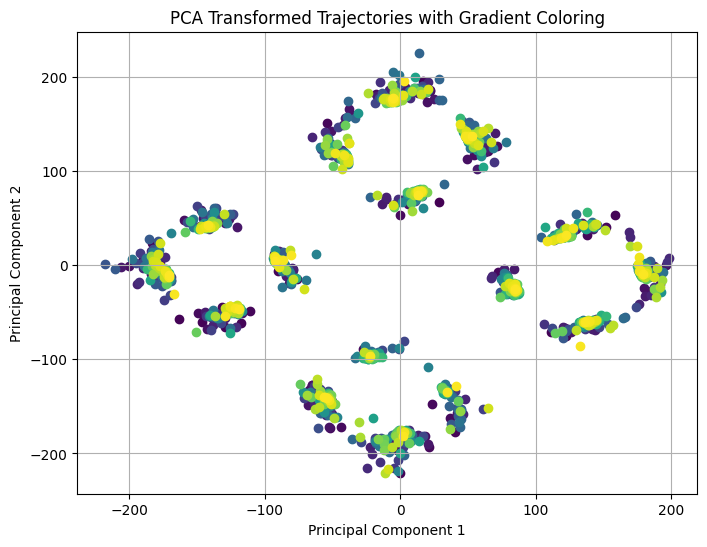

In [ ]:
# Transform each trajectory to PCA space
pca_transformed_trajectories = np.array([transform_trajectory(pca, traj).flatten() for traj in resampled_trajectories])

# Plot the PCA-transformed trajectories
plot_pca_trajectories(pca_transformed_trajectories)

In [ ]:
pca

PCA(n_components=2)

In [ ]:
# Add an overwrite flag
overwrite = True  # Set to True if you want to overwrite existing pickle files

mice_to_process = [mice_list[0]]
for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        print(f'Processing the trajectory of session {session_to_process}')
        if sessionindex==0: # for the first session of a given animal, we get the trapeze coordinates and then we will resuse them for the remaining sesions
            trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_process)
            all_trapezes_coordinates_cm= generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]
            
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not overwrite and os.path.exists(output_pickle_filepath):
            print(f'Pickle file already exists for session {session_to_process}, skipping processing.')
            continue  # Skip processing if the file exists and overwrite is False
        
        # Run the processing if file doesn't exist or overwrite is True
        process_trajectory(folder_path_mouse_to_process, session_to_process,all_trapezes_coordinates_cm)
        print('#########################\n')

Processing mouse MOU2329. There is/are 22 sessions to process:
['MOU2329_20240607-1315', 'MOU2329_20240607-1714', 'MOU2329_20240610-0936', 'MOU2329_20240610-1336', 'MOU2329_20240611-0915', 'MOU2329_20240611-1324', 'MOU2329_20240612-0918', 'MOU2329_20240612-1341', 'MOU2329_20240613-0914', 'MOU2329_20240613-1405', 'MOU2329_20240614-0820', 'MOU2329_20240614-1331', 'MOU2329_20240617-0829', 'MOU2329_20240617-1420', 'MOU2329_20240618-0829', 'MOU2329_20240618-1451', 'MOU2329_20240619-0828', 'MOU2329_20240619-1406', 'MOU2329_20240620-0821', 'MOU2329_20240620-1339', 'MOU2329_20240621-0829', 'MOU2329_20240621-1425'] 

Processing the trajectory of session MOU2329_20240607-1315
Total time: 885.00 s.
The total distance is: 93.80 m
The average running speed is: 10.60 cm/s
Processing run_between_towers epochs...
Processing run_toward_tower epochs...
Processing exploratory_run epochs...
Processing immobility epochs...
Session processing results saved to /Users/davidrobbe/Documents/Science/Data/Foragin

In [ ]:
# Add an overwrite flag
overwrite = True  # Set to True if you want to overwrite existing pickle files

mice_to_process = [mice_list[0]]
for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        print(f'Processing the trajectory of session {session_to_process}')
        if sessionindex==0: # for the first session of a given animal, we get the trapeze coordinates and then we will resuse them for the remaining sesions
            trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_process)
            all_trapezes_coordinates_cm= generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]
            
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not overwrite and os.path.exists(output_pickle_filepath):
            print(f'Pickle file already exists for session {session_to_process}, skipping processing.')
            continue  # Skip processing if the file exists and overwrite is False
        
        # Run the processing if file doesn't exist or overwrite is True
        process_trajectory(folder_path_mouse_to_process, session_to_process,all_trapezes_coordinates_cm)
        print('#########################\n')

Processing mouse MOU2329. There is/are 22 sessions to process:
['MOU2329_20240607-1315', 'MOU2329_20240607-1714', 'MOU2329_20240610-0936', 'MOU2329_20240610-1336', 'MOU2329_20240611-0915', 'MOU2329_20240611-1324', 'MOU2329_20240612-0918', 'MOU2329_20240612-1341', 'MOU2329_20240613-0914', 'MOU2329_20240613-1405', 'MOU2329_20240614-0820', 'MOU2329_20240614-1331', 'MOU2329_20240617-0829', 'MOU2329_20240617-1420', 'MOU2329_20240618-0829', 'MOU2329_20240618-1451', 'MOU2329_20240619-0828', 'MOU2329_20240619-1406', 'MOU2329_20240620-0821', 'MOU2329_20240620-1339', 'MOU2329_20240621-0829', 'MOU2329_20240621-1425'] 

Processing the trajectory of session MOU2329_20240607-1315
Total time: 885.00 s.
The total distance is: 93.80 m
The average running speed is: 10.60 cm/s
Processing run_between_towers epochs...
Processing run_toward_tower epochs...
Processing exploratory_run epochs...
Processing immobility epochs...
Session processing results saved to /Users/davidrobbe/Documents/Science/Data/Foragin

In [ ]:
# Add an overwrite flag
overwrite = True  # Set to True if you want to overwrite existing pickle files

mice_to_process = [mice_list[0]]
for mouse in mice_to_process:
    folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])
    
    nb_sessions = len(sessions_to_process)
    print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
    print(sessions_to_process, '\n')
    
    # Process each session
    for sessionindex,session_to_process in enumerate(sessions_to_process):
        print(f'Processing the trajectory of session {session_to_process}')
        if sessionindex==0: # for the first session of a given animal, we get the trapeze coordinates and then we will resuse them for the remaining sesions
            trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_process)
            all_trapezes_coordinates_cm= generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]
            
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not overwrite and os.path.exists(output_pickle_filepath):
            print(f'Pickle file already exists for session {session_to_process}, skipping processing.')
            continue  # Skip processing if the file exists and overwrite is False
        
        # Run the processing if file doesn't exist or overwrite is True
        process_trajectory(folder_path_mouse_to_process, session_to_process,all_trapezes_coordinates_cm)
        print('#########################\n')

Processing mouse MOU2329. There is/are 22 sessions to process:
['MOU2329_20240607-1315', 'MOU2329_20240607-1714', 'MOU2329_20240610-0936', 'MOU2329_20240610-1336', 'MOU2329_20240611-0915', 'MOU2329_20240611-1324', 'MOU2329_20240612-0918', 'MOU2329_20240612-1341', 'MOU2329_20240613-0914', 'MOU2329_20240613-1405', 'MOU2329_20240614-0820', 'MOU2329_20240614-1331', 'MOU2329_20240617-0829', 'MOU2329_20240617-1420', 'MOU2329_20240618-0829', 'MOU2329_20240618-1451', 'MOU2329_20240619-0828', 'MOU2329_20240619-1406', 'MOU2329_20240620-0821', 'MOU2329_20240620-1339', 'MOU2329_20240621-0829', 'MOU2329_20240621-1425'] 

Processing the trajectory of session MOU2329_20240607-1315
Total time: 885.00 s.
The total distance is: 93.80 m
The average running speed is: 10.60 cm/s
Processing run_between_towers epochs...
Processing run_toward_tower epochs...
Processing exploratory_run epochs...
Processing immobility epochs...
Session processing results saved to /Users/davidrobbe/Documents/Science/Data/Foragin

### Process a defined subset of sessions of a single mice in the mouse_list

In [ ]:
# same of code as above if you want to process a single session for a single mouse (obviously yu can process two or three)
mice_to_process="MOU2333"
sessions_to_process=['MOU2333_20240610-1557', 'MOU2333_20240611-1118']

# Add an overwrite flag
overwrite = True  # Set to True if you want to overwrite existing pickle files

folder_path_mouse_to_process = os.path.join(path_to_data_folder, mice_to_process)

# Get the list of sessions


nb_sessions = len(sessions_to_process)
print(f'Processing mouse {mouse}. There is/are {nb_sessions} sessions to process:')
print(sessions_to_process, '\n')

# Process each session
for sessionindex,session_to_process in enumerate(sessions_to_process):
    print(f'Processing the trajectory of session {session_to_process}')
    if sessionindex==0: # for the first session of a given animal, we get the trapeze coordinates and then we will resuse them for the remaining sesions
        trapeze_width, towers_coordinates = get_trapeze_and_tower_data(folder_path_mouse_to_process, session_to_process)
        all_trapezes_coordinates_cm= generate_trapeze_and_tower_coordinates(towers_coordinates, trapeze_width)[0]
        
    
    # Define the pickle file path
    output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
    output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
    
    # Check if the pickle file already exists
    if not overwrite and os.path.exists(output_pickle_filepath):
        print(f'Pickle file already exists for session {session_to_process}, skipping processing.')
        continue  # Skip processing if the file exists and overwrite is False
    
    # Run the processing if file doesn't exist or overwrite is True
    process_trajectory(folder_path_mouse_to_process, session_to_process,all_trapezes_coordinates_cm)
    print('#########################\n')

Processing mouse MOU2329. There is/are 2 sessions to process:
['MOU2333_20240610-1557', 'MOU2333_20240611-1118'] 

Processing the trajectory of session MOU2333_20240610-1557
Total time: 884.96 s.
The total distance is: 74.38 m
The average running speed is: 8.40 cm/s
Processing run_between_towers epochs...
Processing run_toward_tower epochs...
Processing exploratory_run epochs...
Processing immobility epochs...
Session processing results saved to /LocalData/ForagingMice/JAK2Data/MOU2333/MOU2333_20240610-1557/MOU2333_20240610-1557_basic_processing_output.pickle
#########################

Processing the trajectory of session MOU2333_20240611-1118
Total time: 885.00 s.
The total distance is: 78.86 m
The average running speed is: 8.91 cm/s
Processing run_between_towers epochs...
Processing run_toward_tower epochs...
Processing exploratory_run epochs...
Processing immobility epochs...
Session processing results saved to /LocalData/ForagingMice/JAK2Data/MOU2333/MOU2333_20240611-1118/MOU2333_2